In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2
EPOCH = 100

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [13]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [14]:
perceptual_ext = PerceptualLoss()

In [15]:
sobel_filter = Sobel().to(device)

In [16]:
def train_a2b_epoch(generator, gen_optim, tf_discriminator, tf_d_optim, edge_discriminator, edge_d_optim, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    air_l = 0
    bone_l = 0

    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        set_requires_grad(tf_discriminator, True)
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        set_requires_grad(edge_discriminator, True)
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        set_requires_grad(tf_discriminator, False)
        set_requires_grad(edge_discriminator, False)
        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [17]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [18]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [19]:
from codes.activation import Activation
import torchvision.models as models

In [20]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):

        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.bn1 = nn.InstanceNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=64, out_features=n_classes)

        self.activation = Activation(name=activation)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return self.activation(x)

# Generator

In [21]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [22]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [23]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [24]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [25]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [26]:
len(trainset), len(testset)

(1344, 191)

In [27]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7fc3d8197190>,)

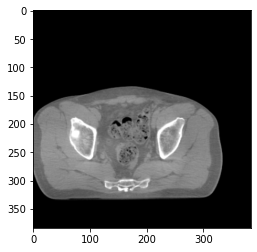

In [28]:
plt.imshow(x.squeeze(), 'gray'),

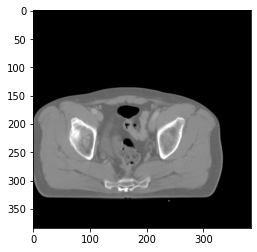

In [29]:
plt.imshow(y.squeeze(), 'gray')

In [30]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [31]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [35]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

In [37]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

min_acc = 99

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer,
                                                                                             edge_discriminator, edge_dis_optimizer,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_tf_acc_test +  score_edge_acc_test <= min_acc:
            min_acc = score_tf_acc_test +  score_edge_acc_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [01:25,  1.01s/it]
84it [00:26,  3.14it/s]
12it [00:04,  2.88it/s]
84it [01:23,  1.01it/s]
84it [00:26,  3.15it/s]
12it [00:04,  2.90it/s]
84it [01:23,  1.01it/s]
84it [00:26,  3.14it/s]
12it [00:04,  2.88it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.12it/s]
12it [00:04,  2.89it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.13it/s]
12it [00:04,  2.87it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.14it/s]
12it [00:04,  2.91it/s]
84it [01:23,  1.01it/s]
84it [00:26,  3.15it/s]
12it [00:04,  2.84it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.14it/s]
12it [00:04,  2.86it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.14it/s]
12it [00:04,  2.85it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.13it/s]
12it [00:04,  2.89it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.14it/s]
12it [00:04,  2.86it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.13it/s]
12it [00:04,  2.88it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.15it/s]
12it [00:04,  2.87it/s]
84it [01:23,  1.00it/s]
84it [00:26,  3.13it/s]
12it [00:04,  2.

In [38]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [40]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [41]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8483594655990601
psnr score = 19.936199188232422
snr score = 9.999136924743652
mae error = 0.05391693860292435
air dice score = 0.9824415524143035
bone dice score = 0.8727965697971606
contour dice score = 0.6929510235786438


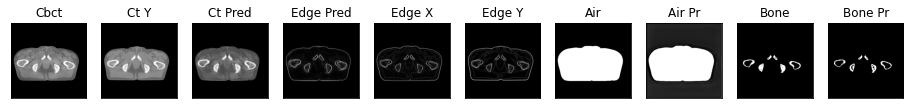

1it [00:00,  2.07it/s]

ssim score = 0.8459089994430542
psnr score = 19.869895935058594
snr score = 9.980368614196777
mae error = 0.05444182828068733
air dice score = 0.9821419948039075
bone dice score = 0.8689873417742249
contour dice score = 0.762417733669281


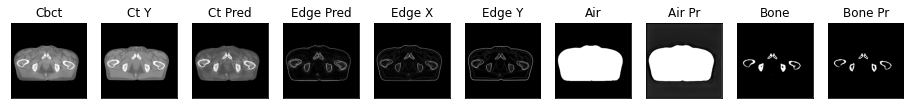

2it [00:01,  1.94it/s]

ssim score = 0.8444379568099976
psnr score = 19.381874084472656
snr score = 9.655244827270508
mae error = 0.057792339473962784
air dice score = 0.9825317801730556
bone dice score = 0.8320905827142766
contour dice score = 0.7153984308242798


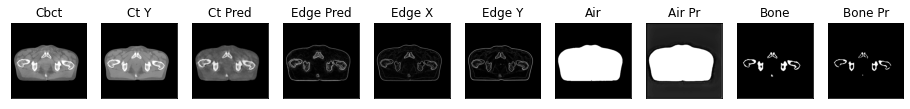

3it [00:01,  2.12it/s]

ssim score = 0.8435940146446228
psnr score = 19.270936965942383
snr score = 9.63355827331543
mae error = 0.05864653363823891
air dice score = 0.9823592664709985
bone dice score = 0.7749347258515021
contour dice score = 0.6322115659713745


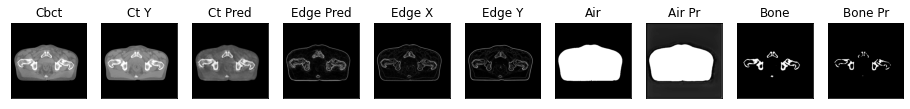

4it [00:01,  2.25it/s]

ssim score = 0.8432837724685669
psnr score = 19.249950408935547
snr score = 9.652873992919922
mae error = 0.058191630989313126
air dice score = 0.9819150073370243
bone dice score = 0.7080960633856388
contour dice score = 0.6313890814781189


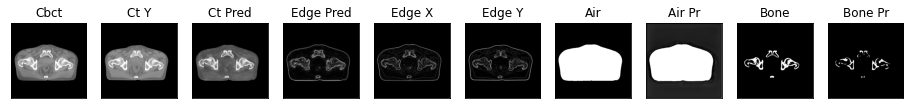

5it [00:02,  2.36it/s]

ssim score = 0.8400511145591736
psnr score = 18.912233352661133
snr score = 9.451693534851074
mae error = 0.060343317687511444
air dice score = 0.9816332903931163
bone dice score = 0.6287371709099873
contour dice score = 0.5765982866287231


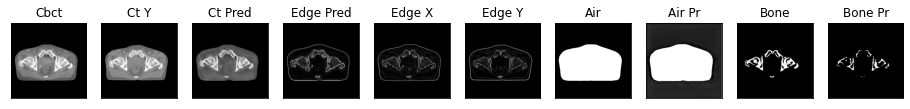

6it [00:02,  2.43it/s]

ssim score = 0.84014892578125
psnr score = 18.87630844116211
snr score = 9.391712188720703
mae error = 0.06027304008603096
air dice score = 0.9806252881682013
bone dice score = 0.6091293505409396
contour dice score = 0.6147342920303345


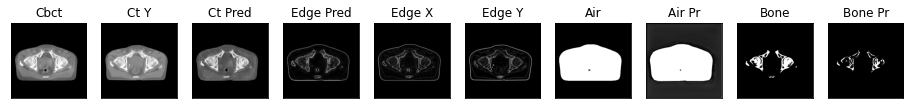

7it [00:02,  2.50it/s]

ssim score = 0.8451640605926514
psnr score = 19.245994567871094
snr score = 9.575860023498535
mae error = 0.05805987864732742
air dice score = 0.9807584200404549
bone dice score = 0.6867469879553677
contour dice score = 0.6905339956283569


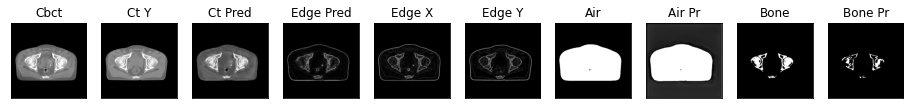

8it [00:03,  2.54it/s]

ssim score = 0.8504267930984497
psnr score = 19.514860153198242
snr score = 9.750170707702637
mae error = 0.05645054578781128
air dice score = 0.9807892570590001
bone dice score = 0.7638872646501708
contour dice score = 0.7081047892570496


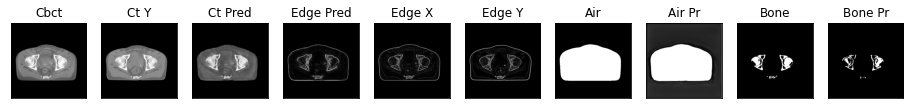

9it [00:03,  2.57it/s]

ssim score = 0.8534383177757263
psnr score = 19.499332427978516
snr score = 9.7193603515625
mae error = 0.05648690462112427
air dice score = 0.980475102513214
bone dice score = 0.7677309285916678
contour dice score = 0.7196090221405029


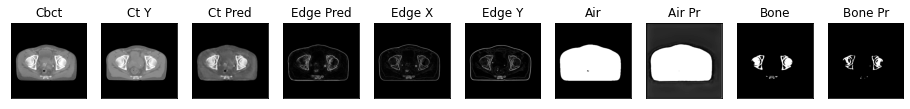

10it [00:04,  2.60it/s]

ssim score = 0.8572556972503662
psnr score = 19.324445724487305
snr score = 9.576742172241211
mae error = 0.05788229778409004
air dice score = 0.9808479884365405
bone dice score = 0.8305769937543724
contour dice score = 0.7313797473907471


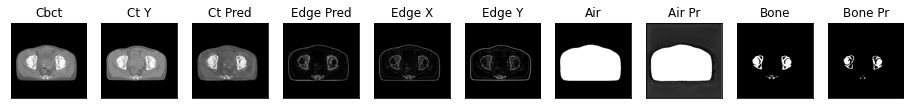

11it [00:04,  2.26it/s]

ssim score = 0.8542744517326355
psnr score = 19.07035255432129
snr score = 9.346360206604004
mae error = 0.05930202454328537
air dice score = 0.9790100694937101
bone dice score = 0.7946281515292711
contour dice score = 0.6638141870498657


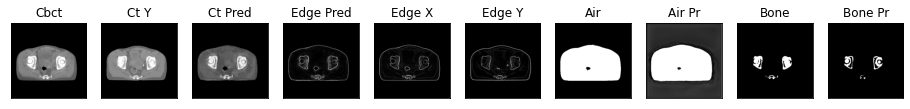

12it [00:05,  2.37it/s]

ssim score = 0.8570470213890076
psnr score = 18.9635009765625
snr score = 9.207586288452148
mae error = 0.059610527008771896
air dice score = 0.9778341758939214
bone dice score = 0.8671435871248449
contour dice score = 0.6364749073982239


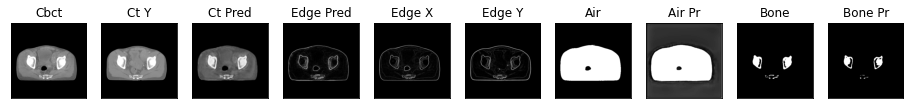

13it [00:05,  2.45it/s]

ssim score = 0.85515958070755
psnr score = 19.289600372314453
snr score = 9.391728401184082
mae error = 0.056427109986543655
air dice score = 0.9767379541355561
bone dice score = 0.8170836928412843
contour dice score = 0.6043077111244202


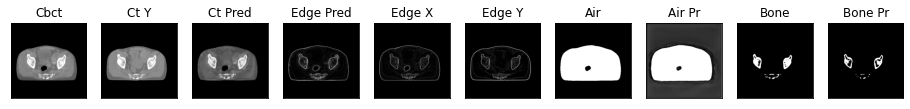

14it [00:05,  2.52it/s]

ssim score = 0.8530431389808655
psnr score = 19.43985939025879
snr score = 9.456327438354492
mae error = 0.054952047765254974
air dice score = 0.9754935964467522
bone dice score = 0.8063433973802021
contour dice score = 0.5132307410240173


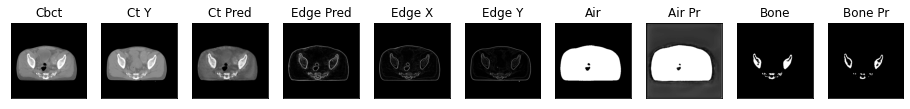

15it [00:06,  2.57it/s]

ssim score = 0.8470596075057983
psnr score = 19.3382511138916
snr score = 9.378202438354492
mae error = 0.05547498166561127
air dice score = 0.9715839508479445
bone dice score = 0.8003538779150641
contour dice score = 0.4934416115283966


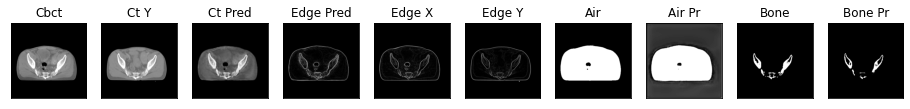

16it [00:06,  2.59it/s]

ssim score = 0.8413891792297363
psnr score = 19.14290428161621
snr score = 9.180313110351562
mae error = 0.05610790476202965
air dice score = 0.9699821821612304
bone dice score = 0.7769537935000435
contour dice score = 0.4965517222881317


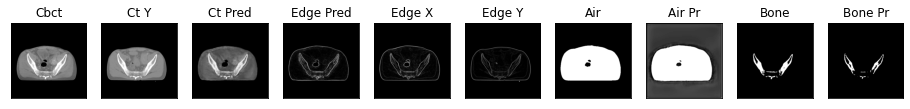

17it [00:06,  2.62it/s]

ssim score = 0.835335910320282
psnr score = 19.193178176879883
snr score = 9.128824234008789
mae error = 0.054887961596250534
air dice score = 0.9670067380605718
bone dice score = 0.7385205964899082
contour dice score = 0.4185185134410858


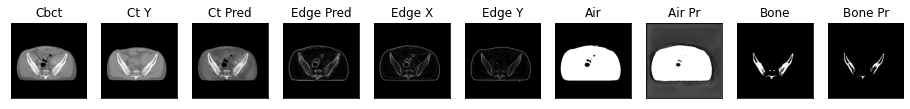

18it [00:07,  2.64it/s]

ssim score = 0.8333176374435425
psnr score = 19.154422760009766
snr score = 9.039387702941895
mae error = 0.05460860952734947
air dice score = 0.9651809993202274
bone dice score = 0.7064261219665062
contour dice score = 0.33142855763435364


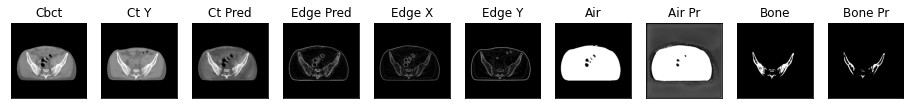

19it [00:07,  2.65it/s]

ssim score = 0.838553249835968
psnr score = 19.244714736938477
snr score = 9.11737060546875
mae error = 0.054227281361818314
air dice score = 0.9647729456222754
bone dice score = 0.7416704019163055
contour dice score = 0.3305993676185608


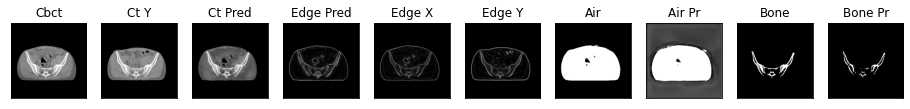

20it [00:08,  2.66it/s]

ssim score = 0.8349251747131348
psnr score = 19.3594970703125
snr score = 9.167305946350098
mae error = 0.05356868356466293
air dice score = 0.9624743508482081
bone dice score = 0.7576575146840556
contour dice score = 0.3726707994937897


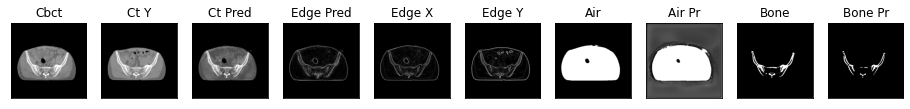

21it [00:08,  2.28it/s]

ssim score = 0.8269085884094238
psnr score = 19.375009536743164
snr score = 9.123387336730957
mae error = 0.05340278893709183
air dice score = 0.9583571021107122
bone dice score = 0.7441269841310456
contour dice score = 0.24542124569416046


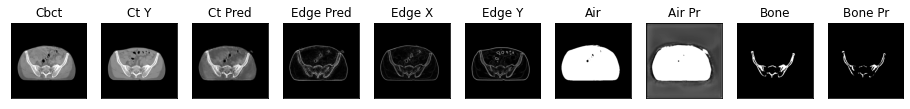

22it [00:08,  2.39it/s]

ssim score = 0.8330573439598083
psnr score = 19.548437118530273
snr score = 9.263389587402344
mae error = 0.052109040319919586
air dice score = 0.9585995928543108
bone dice score = 0.7306763285064813
contour dice score = 0.20434227585792542


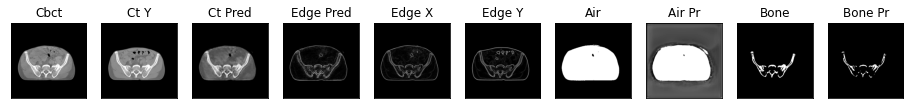

23it [00:09,  2.46it/s]

ssim score = 0.8350483179092407
psnr score = 19.70408058166504
snr score = 9.370467185974121
mae error = 0.05084368214011192
air dice score = 0.9568183563116747
bone dice score = 0.7078335554611604
contour dice score = 0.17583808302879333


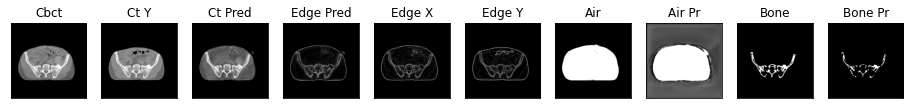

24it [00:09,  2.53it/s]

ssim score = 0.836885929107666
psnr score = 19.83155632019043
snr score = 9.400941848754883
mae error = 0.04947799816727638
air dice score = 0.9513991163476238
bone dice score = 0.6934948795659384
contour dice score = 0.15620827674865723


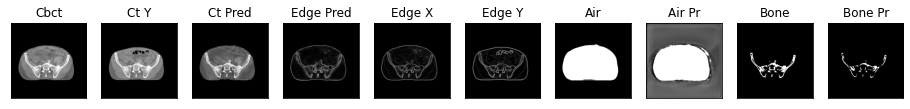

25it [00:10,  2.56it/s]

ssim score = 0.8429355621337891
psnr score = 20.026323318481445
snr score = 9.51297664642334
mae error = 0.04818937927484512
air dice score = 0.9141229052710352
bone dice score = 0.6808016264931629
contour dice score = 0.1228899359703064


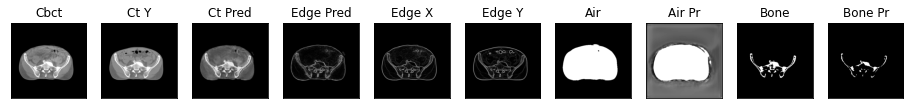

26it [00:10,  2.60it/s]

ssim score = 0.8426329493522644
psnr score = 20.252092361450195
snr score = 9.64755916595459
mae error = 0.046539805829524994
air dice score = 0.7981621139568851
bone dice score = 0.654640675012298
contour dice score = 0.06611569970846176


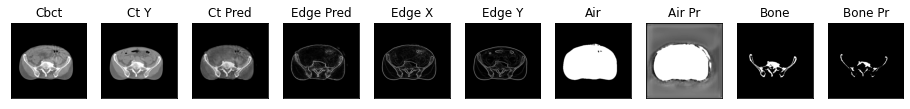

27it [00:10,  2.62it/s]

ssim score = 0.8355820178985596
psnr score = 20.07541847229004
snr score = 9.429780006408691
mae error = 0.0471467487514019
air dice score = 0.6657321561782901
bone dice score = 0.6493542563581537
contour dice score = 0.09848485141992569


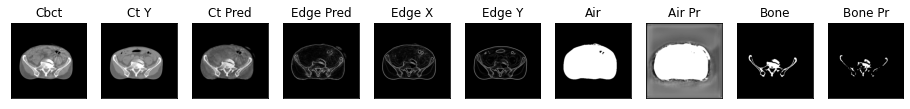

28it [00:11,  2.64it/s]

ssim score = 0.7824386358261108
psnr score = 17.680402755737305
snr score = 9.052558898925781
mae error = 0.08585810661315918
air dice score = 0.9898936005211466
bone dice score = 0.8921232876743116
contour dice score = 0.15674518048763275


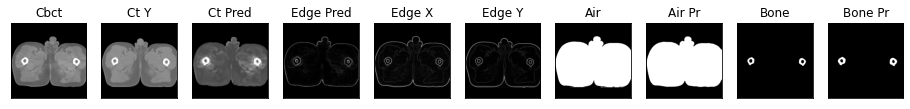

29it [00:11,  2.65it/s]

ssim score = 0.7850159406661987
psnr score = 17.683740615844727
snr score = 9.095154762268066
mae error = 0.08652932196855545
air dice score = 0.988394477074948
bone dice score = 0.9043760129685474
contour dice score = 0.1404399275779724


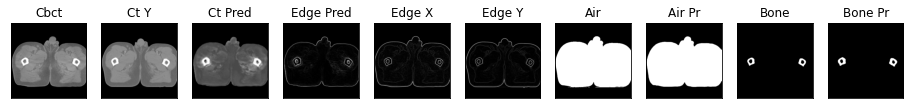

30it [00:11,  2.66it/s]

ssim score = 0.7881481647491455
psnr score = 17.590862274169922
snr score = 9.089726448059082
mae error = 0.08786465227603912
air dice score = 0.9881274632611359
bone dice score = 0.9068457539014981
contour dice score = 0.1426660716533661


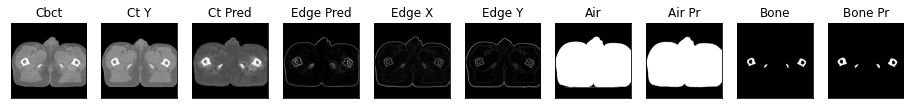

31it [00:12,  2.28it/s]

ssim score = 0.783502995967865
psnr score = 17.251203536987305
snr score = 8.912622451782227
mae error = 0.09208217263221741
air dice score = 0.9877866309835243
bone dice score = 0.9376059158844923
contour dice score = 0.1519925892353058


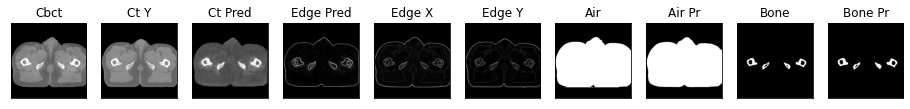

32it [00:12,  2.38it/s]

ssim score = 0.7826639413833618
psnr score = 17.1839656829834
snr score = 8.973529815673828
mae error = 0.09283582866191864
air dice score = 0.9880981208833858
bone dice score = 0.9220674879496241
contour dice score = 0.15499533712863922


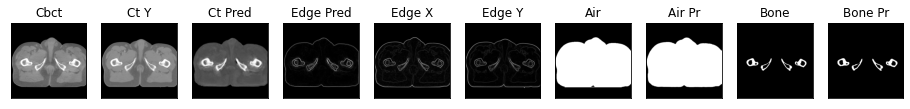

33it [00:13,  2.46it/s]

ssim score = 0.7834874391555786
psnr score = 17.08955955505371
snr score = 8.98236083984375
mae error = 0.09405741840600967
air dice score = 0.9878363702184217
bone dice score = 0.906634787807452
contour dice score = 0.15708275139331818


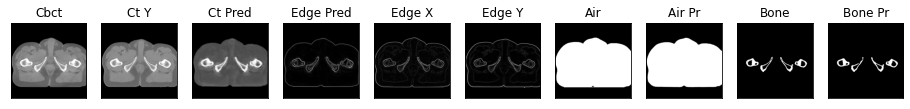

34it [00:13,  2.52it/s]

ssim score = 0.7829123139381409
psnr score = 17.059871673583984
snr score = 9.019774436950684
mae error = 0.09443645179271698
air dice score = 0.9868012609187461
bone dice score = 0.8990581717462708
contour dice score = 0.1568627506494522


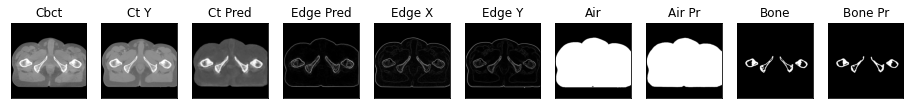

35it [00:14,  2.56it/s]

ssim score = 0.7857542037963867
psnr score = 17.146677017211914
snr score = 9.09669017791748
mae error = 0.09361180663108826
air dice score = 0.9866746662666946
bone dice score = 0.9212430821634606
contour dice score = 0.15742896497249603


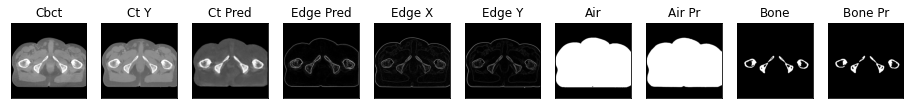

36it [00:14,  2.60it/s]

ssim score = 0.7890398502349854
psnr score = 17.15389060974121
snr score = 9.090238571166992
mae error = 0.09364810585975647
air dice score = 0.9867573457218882
bone dice score = 0.9326677994909445
contour dice score = 0.15563839673995972


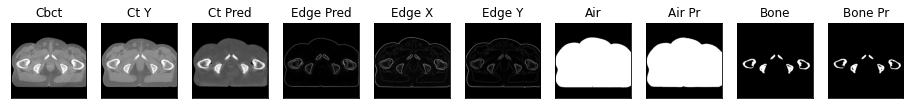

37it [00:14,  2.61it/s]

ssim score = 0.7893961071968079
psnr score = 17.18402862548828
snr score = 9.132379531860352
mae error = 0.0935274064540863
air dice score = 0.9869421724781252
bone dice score = 0.9225100491299407
contour dice score = 0.15642458200454712


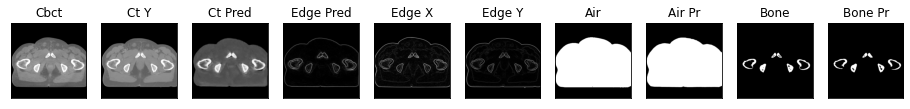

38it [00:15,  2.63it/s]

ssim score = 0.7873599529266357
psnr score = 17.121898651123047
snr score = 9.109333992004395
mae error = 0.09450411051511765
air dice score = 0.9870995883101673
bone dice score = 0.9145074763164648
contour dice score = 0.15708275139331818


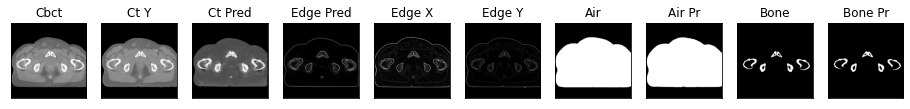

39it [00:15,  2.63it/s]

ssim score = 0.7834743857383728
psnr score = 16.87470245361328
snr score = 9.003425598144531
mae error = 0.09763319790363312
air dice score = 0.9869636164757013
bone dice score = 0.9062247372685305
contour dice score = 0.15355804562568665


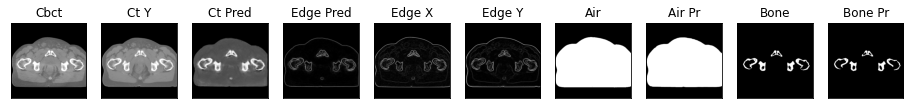

40it [00:15,  2.65it/s]

ssim score = 0.7784611582756042
psnr score = 16.783363342285156
snr score = 9.0067720413208
mae error = 0.0982215479016304
air dice score = 0.9866815115436957
bone dice score = 0.8718218481512202
contour dice score = 0.1525423675775528


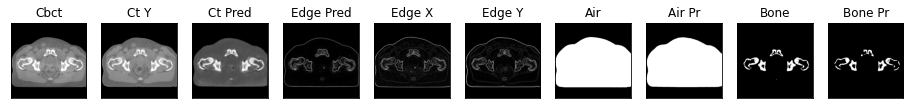

41it [00:16,  2.28it/s]

ssim score = 0.7650777101516724
psnr score = 16.698135375976562
snr score = 8.88749885559082
mae error = 0.0975407138466835
air dice score = 0.9863573286556253
bone dice score = 0.812488943925239
contour dice score = 0.15101462602615356


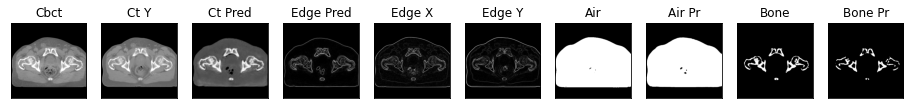

42it [00:16,  2.38it/s]

ssim score = 0.7610739469528198
psnr score = 16.41620445251465
snr score = 8.677755355834961
mae error = 0.09996451437473297
air dice score = 0.9845652858145991
bone dice score = 0.7399420663039915
contour dice score = 0.16401124000549316


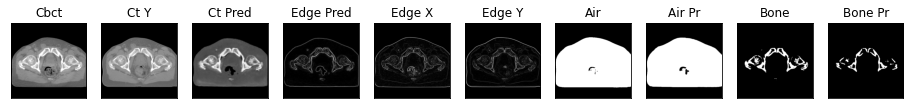

43it [00:17,  2.46it/s]

ssim score = 0.7680041790008545
psnr score = 16.624446868896484
snr score = 8.749902725219727
mae error = 0.09774057567119598
air dice score = 0.9862250932581287
bone dice score = 0.8087695576607228
contour dice score = 0.16955503821372986


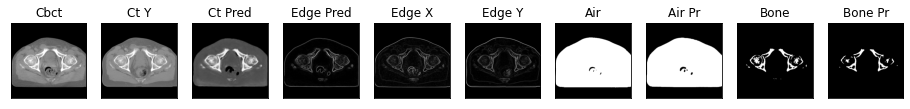

44it [00:17,  2.52it/s]

ssim score = 0.7762223482131958
psnr score = 17.05617904663086
snr score = 9.003072738647461
mae error = 0.09272251278162003
air dice score = 0.9873385421096836
bone dice score = 0.8364524003271313
contour dice score = 0.17538896203041077


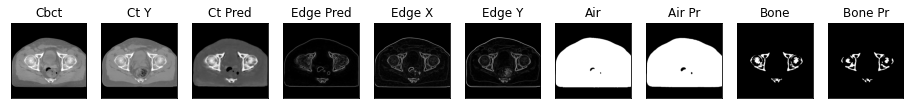

45it [00:18,  2.56it/s]

ssim score = 0.7777783870697021
psnr score = 17.272340774536133
snr score = 9.128645896911621
mae error = 0.09079836308956146
air dice score = 0.9881185469846476
bone dice score = 0.8436907285524523
contour dice score = 0.18130043148994446


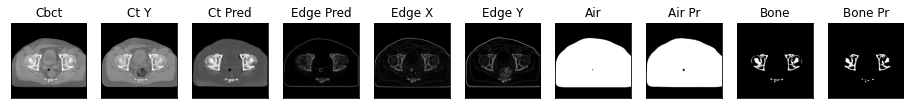

46it [00:18,  2.60it/s]

ssim score = 0.7823373675346375
psnr score = 17.249692916870117
snr score = 9.121688842773438
mae error = 0.09090647846460342
air dice score = 0.9886880452234074
bone dice score = 0.8566909205962596
contour dice score = 0.18898385763168335


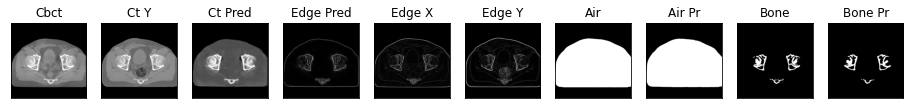

47it [00:18,  2.61it/s]

ssim score = 0.7765892744064331
psnr score = 17.244342803955078
snr score = 9.126373291015625
mae error = 0.09096821397542953
air dice score = 0.9886927659470108
bone dice score = 0.8639237428278969
contour dice score = 0.1901576668024063


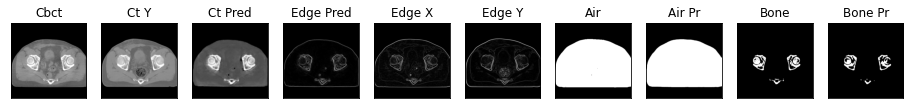

48it [00:19,  2.63it/s]

ssim score = 0.7843977212905884
psnr score = 17.161340713500977
snr score = 9.104961395263672
mae error = 0.09235498309135437
air dice score = 0.9883361456319122
bone dice score = 0.8662358010197196
contour dice score = 0.18633539974689484


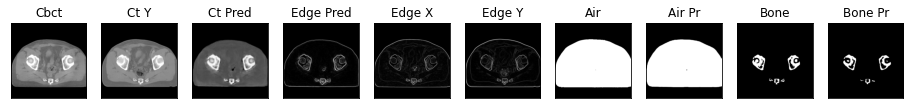

49it [00:19,  2.64it/s]

ssim score = 0.7846621870994568
psnr score = 16.99515151977539
snr score = 9.008853912353516
mae error = 0.09449067711830139
air dice score = 0.9882698490074797
bone dice score = 0.8972525404601313
contour dice score = 0.18303145468235016


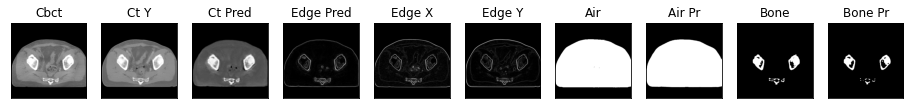

50it [00:19,  2.65it/s]

ssim score = 0.7884698510169983
psnr score = 17.206321716308594
snr score = 9.10091781616211
mae error = 0.0918474942445755
air dice score = 0.9882877101177472
bone dice score = 0.8907109496638225
contour dice score = 0.17279236018657684


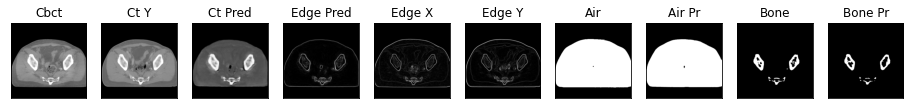

51it [00:20,  2.27it/s]

ssim score = 0.7855381369590759
psnr score = 17.147478103637695
snr score = 9.123702049255371
mae error = 0.09249676764011383
air dice score = 0.9874868883815713
bone dice score = 0.8854347627330581
contour dice score = 0.16586768627166748


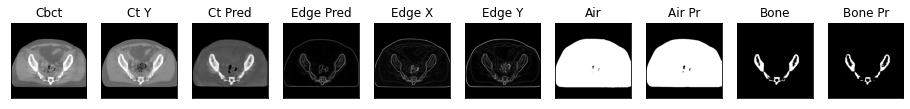

52it [00:20,  2.37it/s]

ssim score = 0.7833627462387085
psnr score = 17.085159301757812
snr score = 9.141531944274902
mae error = 0.09347433596849442
air dice score = 0.985431084465178
bone dice score = 0.8300947486764887
contour dice score = 0.15421456098556519


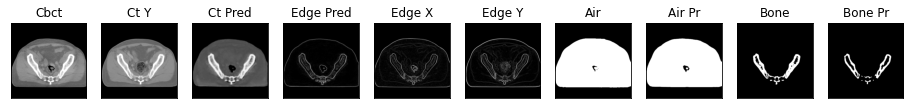

53it [00:21,  2.45it/s]

ssim score = 0.7726174592971802
psnr score = 17.03668785095215
snr score = 9.114615440368652
mae error = 0.09373739361763
air dice score = 0.9862250482738348
bone dice score = 0.8274148296607021
contour dice score = 0.14092664420604706


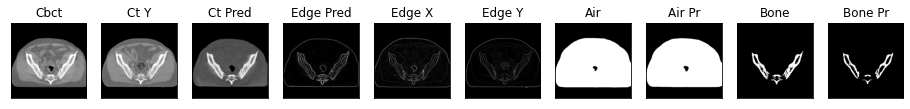

54it [00:21,  2.51it/s]

ssim score = 0.7779543399810791
psnr score = 17.127506256103516
snr score = 9.217975616455078
mae error = 0.09265372902154922
air dice score = 0.9863580092572912
bone dice score = 0.8418776033335319
contour dice score = 0.10638298094272614


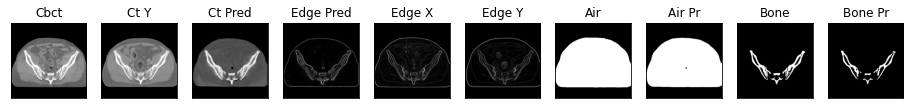

55it [00:21,  2.55it/s]

ssim score = 0.7758762240409851
psnr score = 18.541465759277344
snr score = 8.421671867370605
mae error = 0.06255050748586655
air dice score = 0.9872749269257713
bone dice score = 0.9348290598308006
contour dice score = 0.5041550993919373


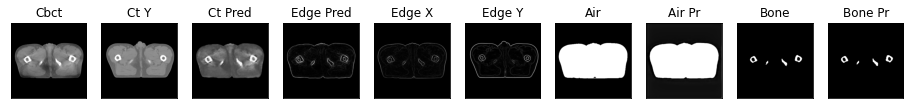

56it [00:22,  2.59it/s]

ssim score = 0.7688475847244263
psnr score = 18.149423599243164
snr score = 8.242612838745117
mae error = 0.06626378744840622
air dice score = 0.9882491496673479
bone dice score = 0.9090909090928491
contour dice score = 0.4740331470966339


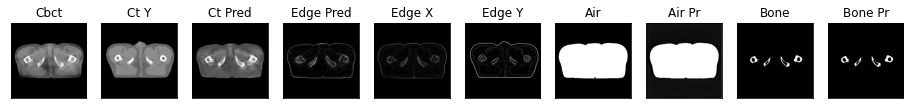

57it [00:22,  2.61it/s]

ssim score = 0.7662151455879211
psnr score = 18.05156898498535
snr score = 8.275896072387695
mae error = 0.06738010793924332
air dice score = 0.9881669742262285
bone dice score = 0.8741641337411516
contour dice score = 0.4884488582611084


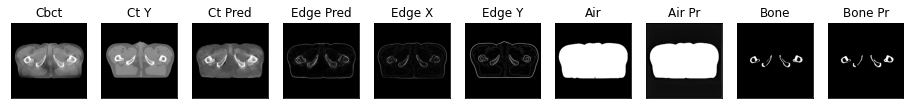

58it [00:23,  2.64it/s]

ssim score = 0.7695447206497192
psnr score = 18.154115676879883
snr score = 8.448845863342285
mae error = 0.06696722656488419
air dice score = 0.9886470485808909
bone dice score = 0.8833629366512066
contour dice score = 0.39297476410865784


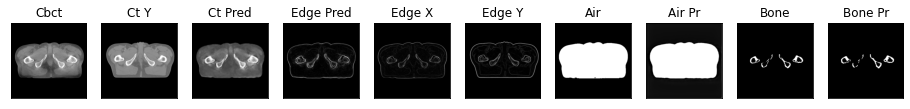

59it [00:23,  2.65it/s]

ssim score = 0.7679843902587891
psnr score = 18.06796646118164
snr score = 8.410264015197754
mae error = 0.06763824820518494
air dice score = 0.9877051315446838
bone dice score = 0.8751688211484628
contour dice score = 0.3172866404056549


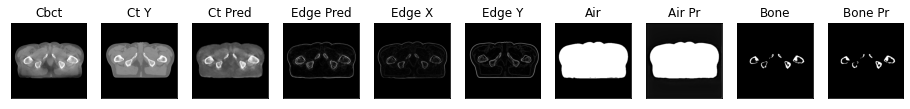

60it [00:23,  2.66it/s]

ssim score = 0.7655192017555237
psnr score = 18.213546752929688
snr score = 8.561457633972168
mae error = 0.06670083850622177
air dice score = 0.9879832856067723
bone dice score = 0.8804653781219653
contour dice score = 0.3292488157749176


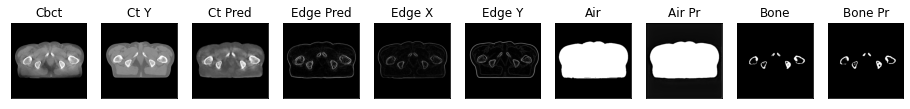

61it [00:24,  2.28it/s]

ssim score = 0.7684447169303894
psnr score = 18.31047248840332
snr score = 8.651880264282227
mae error = 0.06638029962778091
air dice score = 0.9876564508198948
bone dice score = 0.8868175765667335
contour dice score = 0.31146666407585144


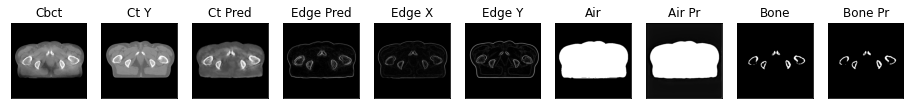

62it [00:24,  2.38it/s]

ssim score = 0.7709291577339172
psnr score = 18.261154174804688
snr score = 8.616671562194824
mae error = 0.06736250221729279
air dice score = 0.9874230067788553
bone dice score = 0.8780756518568109
contour dice score = 0.2781033515930176


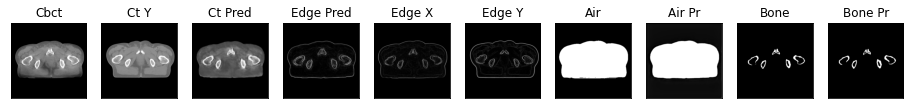

63it [00:25,  2.46it/s]

ssim score = 0.7710179686546326
psnr score = 18.12411880493164
snr score = 8.537646293640137
mae error = 0.06900589168071747
air dice score = 0.9872619129478208
bone dice score = 0.8705485232089358
contour dice score = 0.29474812746047974


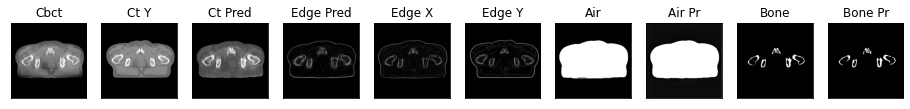

64it [00:25,  2.52it/s]

ssim score = 0.7624111771583557
psnr score = 17.979145050048828
snr score = 8.491231918334961
mae error = 0.0705067589879036
air dice score = 0.9869962883275298
bone dice score = 0.8311432325914727
contour dice score = 0.2481442242860794


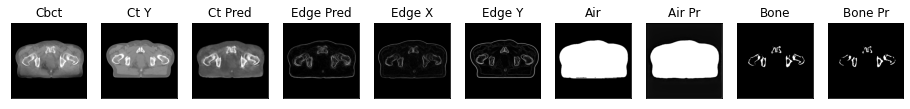

65it [00:25,  2.57it/s]

ssim score = 0.7577242851257324
psnr score = 17.862323760986328
snr score = 8.410238265991211
mae error = 0.07119371742010117
air dice score = 0.9869555907670019
bone dice score = 0.815078466270586
contour dice score = 0.22773879766464233


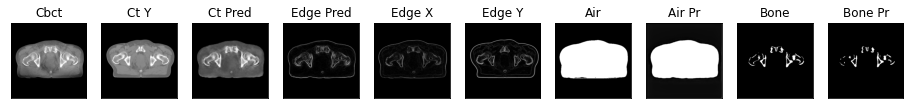

66it [00:26,  2.60it/s]

ssim score = 0.7452620267868042
psnr score = 17.723405838012695
snr score = 8.30402660369873
mae error = 0.0717044249176979
air dice score = 0.9872550363163053
bone dice score = 0.7413234613644714
contour dice score = 0.26222461462020874


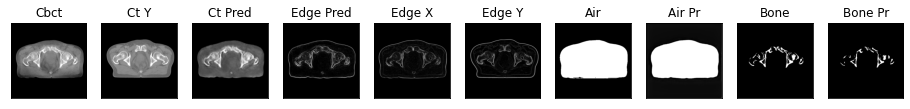

67it [00:26,  2.62it/s]

ssim score = 0.7468026280403137
psnr score = 17.570899963378906
snr score = 8.268338203430176
mae error = 0.0728786364197731
air dice score = 0.9877029189522342
bone dice score = 0.7769138756014218
contour dice score = 0.3195767104625702


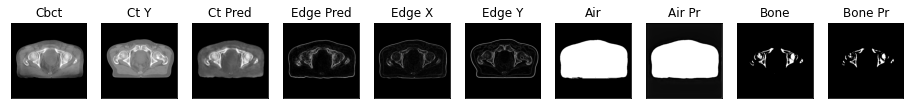

68it [00:27,  2.64it/s]

ssim score = 0.7526816725730896
psnr score = 17.500532150268555
snr score = 8.181984901428223
mae error = 0.07274831086397171
air dice score = 0.9877770269692434
bone dice score = 0.8114588198690416
contour dice score = 0.3735663592815399


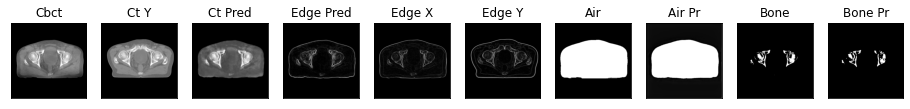

69it [00:27,  2.65it/s]

ssim score = 0.7655081152915955
psnr score = 18.036508560180664
snr score = 8.518797874450684
mae error = 0.0689024105668068
air dice score = 0.9871306250106927
bone dice score = 0.8596601636271293
contour dice score = 0.4168013036251068


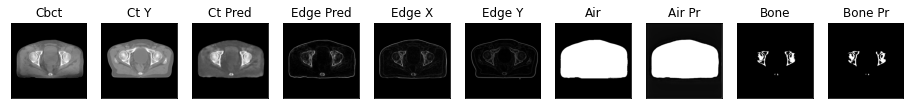

70it [00:27,  2.66it/s]

ssim score = 0.7796944379806519
psnr score = 18.489049911499023
snr score = 8.800944328308105
mae error = 0.06610193103551865
air dice score = 0.9871884542554571
bone dice score = 0.901127493496659
contour dice score = 0.36717063188552856


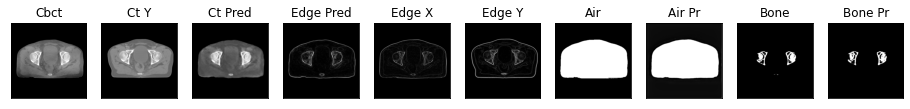

71it [00:28,  2.29it/s]

ssim score = 0.7871041297912598
psnr score = 18.655086517333984
snr score = 8.981149673461914
mae error = 0.0650201365351677
air dice score = 0.9871589631799558
bone dice score = 0.8857828603715123
contour dice score = 0.3792179822921753


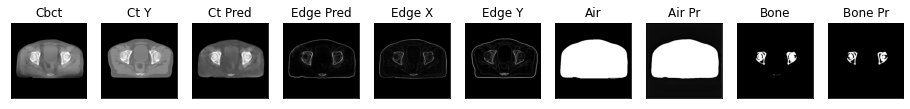

72it [00:28,  2.39it/s]

ssim score = 0.7891736030578613
psnr score = 18.5084171295166
snr score = 8.916309356689453
mae error = 0.06623955816030502
air dice score = 0.9871580217744307
bone dice score = 0.907582260373282
contour dice score = 0.33496466279029846


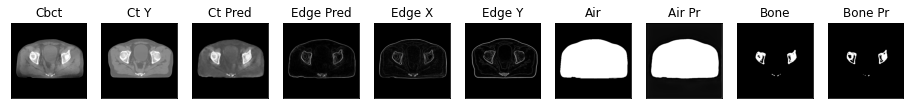

73it [00:29,  2.47it/s]

ssim score = 0.7846717834472656
psnr score = 18.56421661376953
snr score = 9.06428050994873
mae error = 0.06556577235460281
air dice score = 0.9875475760581275
bone dice score = 0.9072004965874115
contour dice score = 0.2917127013206482


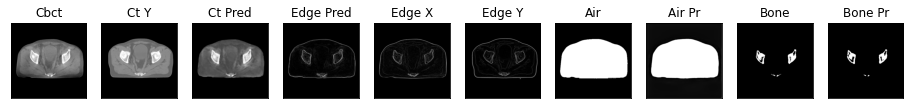

74it [00:29,  2.53it/s]

ssim score = 0.7837738990783691
psnr score = 18.685375213623047
snr score = 9.122013092041016
mae error = 0.06490017473697662
air dice score = 0.9885838382302088
bone dice score = 0.9148369926827206
contour dice score = 0.32025793194770813


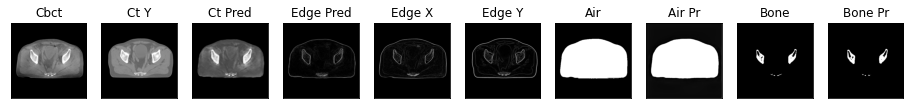

75it [00:29,  2.57it/s]

ssim score = 0.7860381603240967
psnr score = 18.868175506591797
snr score = 9.26841926574707
mae error = 0.06331391632556915
air dice score = 0.9883056242770273
bone dice score = 0.9152421652436744
contour dice score = 0.3285333216190338


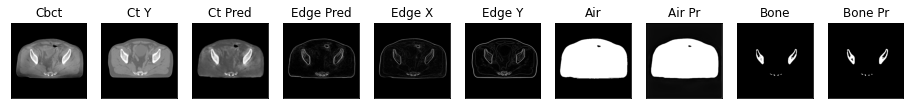

76it [00:30,  2.61it/s]

ssim score = 0.7850506901741028
psnr score = 18.664878845214844
snr score = 9.102869987487793
mae error = 0.06493769586086273
air dice score = 0.9877719227131572
bone dice score = 0.8728725251845628
contour dice score = 0.33954229950904846


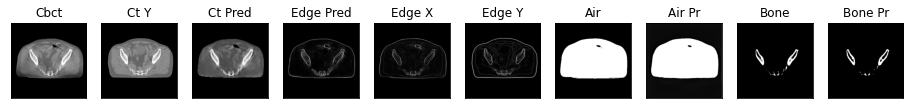

77it [00:30,  2.61it/s]

ssim score = 0.7872946262359619
psnr score = 18.55474090576172
snr score = 9.123236656188965
mae error = 0.06606998294591904
air dice score = 0.9880282047380002
bone dice score = 0.8622534780635643
contour dice score = 0.35672202706336975


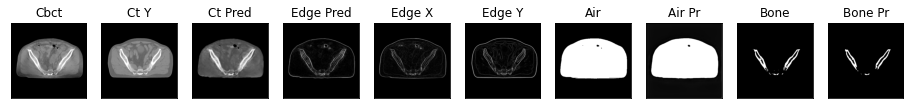

78it [00:31,  2.63it/s]

ssim score = 0.7841376662254333
psnr score = 18.573116302490234
snr score = 9.1593599319458
mae error = 0.06491527706384659
air dice score = 0.9881424266859159
bone dice score = 0.8282958199384518
contour dice score = 0.32310178875923157


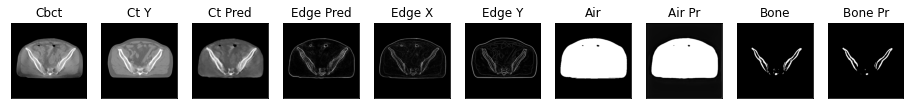

79it [00:31,  2.65it/s]

ssim score = 0.7891377210617065
psnr score = 18.77353286743164
snr score = 9.34850788116455
mae error = 0.06369995325803757
air dice score = 0.9874684580236075
bone dice score = 0.8365945760412531
contour dice score = 0.3551705479621887


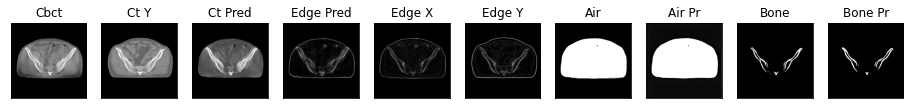

80it [00:31,  2.66it/s]

ssim score = 0.7922407388687134
psnr score = 18.842853546142578
snr score = 9.41708755493164
mae error = 0.06321065872907639
air dice score = 0.9874316612623203
bone dice score = 0.8145393068501345
contour dice score = 0.36333879828453064


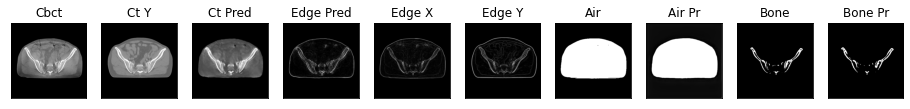

81it [00:32,  2.29it/s]

ssim score = 0.8092367649078369
psnr score = 18.98756217956543
snr score = 9.421695709228516
mae error = 0.06497208029031754
air dice score = 0.9902960227137997
bone dice score = 0.8455978975083575
contour dice score = 0.35557928681373596


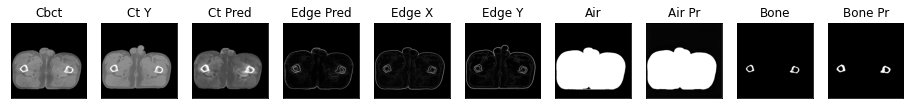

82it [00:32,  2.39it/s]

ssim score = 0.8113065958023071
psnr score = 18.937122344970703
snr score = 9.435648918151855
mae error = 0.06589824706315994
air dice score = 0.9901067962692162
bone dice score = 0.8400724200410359
contour dice score = 0.2890295386314392


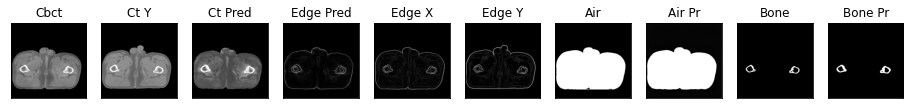

83it [00:33,  2.46it/s]

ssim score = 0.8153980374336243
psnr score = 18.744056701660156
snr score = 9.381795883178711
mae error = 0.06929174810647964
air dice score = 0.9903771293326349
bone dice score = 0.8813767670583614
contour dice score = 0.1769820898771286


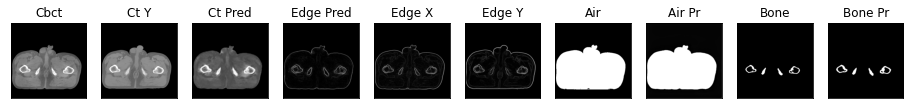

84it [00:33,  2.52it/s]

ssim score = 0.8157448172569275
psnr score = 18.673097610473633
snr score = 9.432328224182129
mae error = 0.07009971886873245
air dice score = 0.9911360431420626
bone dice score = 0.8431671107757296
contour dice score = 0.18115942180156708


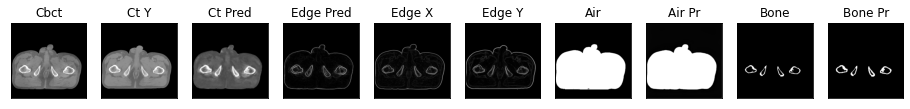

85it [00:33,  2.57it/s]

ssim score = 0.8135107755661011
psnr score = 18.712766647338867
snr score = 9.496169090270996
mae error = 0.06975886970758438
air dice score = 0.9911278532808447
bone dice score = 0.8054489639331265
contour dice score = 0.1533646285533905


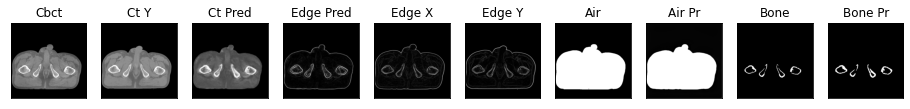

86it [00:34,  2.60it/s]

ssim score = 0.8133660554885864
psnr score = 18.677143096923828
snr score = 9.456149101257324
mae error = 0.07008152455091476
air dice score = 0.9910260869565287
bone dice score = 0.8276110012614127
contour dice score = 0.14608512818813324


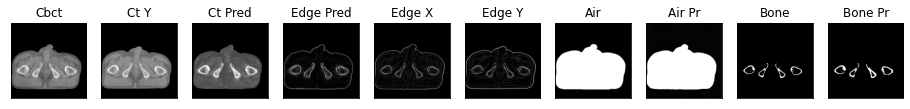

87it [00:34,  2.62it/s]

ssim score = 0.8135740160942078
psnr score = 18.660917282104492
snr score = 9.446178436279297
mae error = 0.07000372558832169
air dice score = 0.9911945993542775
bone dice score = 0.8474515434341807
contour dice score = 0.11770888417959213


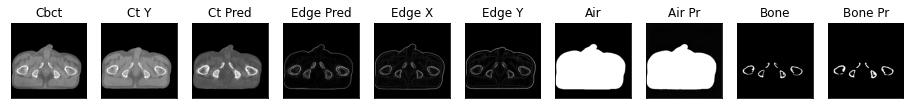

88it [00:34,  2.63it/s]

ssim score = 0.8100153207778931
psnr score = 18.69626808166504
snr score = 9.459973335266113
mae error = 0.06970606744289398
air dice score = 0.9911463367485087
bone dice score = 0.8451671183406474
contour dice score = 0.19820769131183624


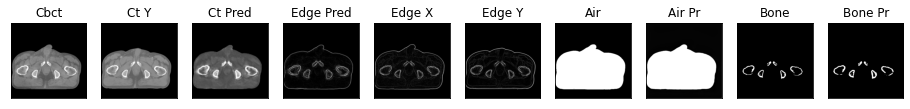

89it [00:35,  2.65it/s]

ssim score = 0.8132866621017456
psnr score = 18.732585906982422
snr score = 9.513202667236328
mae error = 0.06929594278335571
air dice score = 0.9910872058778009
bone dice score = 0.8723809523831623
contour dice score = 0.17777778208255768


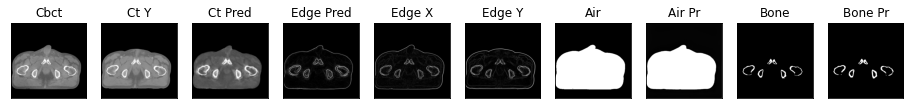

90it [00:35,  2.66it/s]

ssim score = 0.8135839700698853
psnr score = 18.659976959228516
snr score = 9.509187698364258
mae error = 0.06984809786081314
air dice score = 0.9907448489518944
bone dice score = 0.8635774465349388
contour dice score = 0.21176470816135406


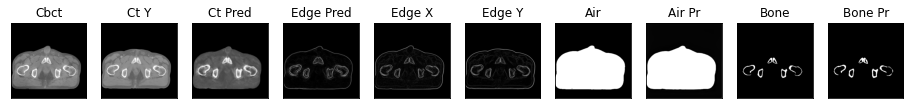

91it [00:36,  2.28it/s]

ssim score = 0.8126047253608704
psnr score = 18.578453063964844
snr score = 9.509018898010254
mae error = 0.07037815451622009
air dice score = 0.990477977391067
bone dice score = 0.8587223587245282
contour dice score = 0.22461041808128357


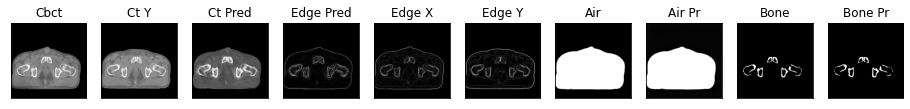

92it [00:36,  2.39it/s]

ssim score = 0.8133665323257446
psnr score = 18.598936080932617
snr score = 9.580206871032715
mae error = 0.07012331485748291
air dice score = 0.9902290867139201
bone dice score = 0.8273674671525847
contour dice score = 0.25591397285461426


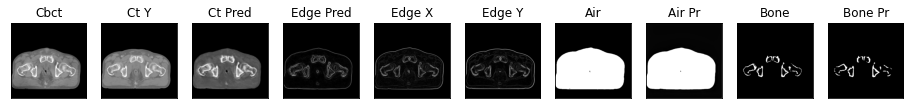

93it [00:37,  2.46it/s]

ssim score = 0.8156604170799255
psnr score = 18.469030380249023
snr score = 9.566570281982422
mae error = 0.07108337432146072
air dice score = 0.9907163161334592
bone dice score = 0.7972692193559325
contour dice score = 0.2024771124124527


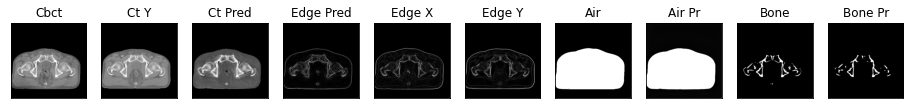

94it [00:37,  2.53it/s]

ssim score = 0.8134403824806213
psnr score = 18.505098342895508
snr score = 9.56440258026123
mae error = 0.06968247890472412
air dice score = 0.990558347512967
bone dice score = 0.7765740304635489
contour dice score = 0.24771136045455933


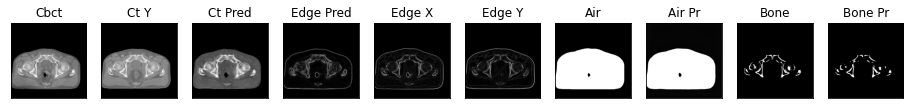

95it [00:37,  2.57it/s]

ssim score = 0.8108556866645813
psnr score = 18.385486602783203
snr score = 9.349120140075684
mae error = 0.07024472206830978
air dice score = 0.9907856140798441
bone dice score = 0.7775836972375898
contour dice score = 0.16082029044628143


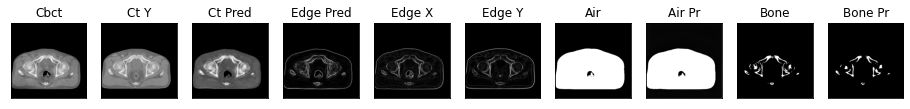

96it [00:38,  2.60it/s]

ssim score = 0.81513911485672
psnr score = 18.50183868408203
snr score = 9.30571174621582
mae error = 0.06910604983568192
air dice score = 0.9912912383121432
bone dice score = 0.8187830687860651
contour dice score = 0.2291891872882843


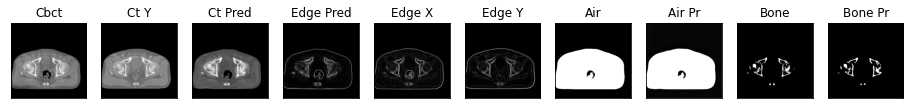

97it [00:38,  2.62it/s]

ssim score = 0.8194000124931335
psnr score = 18.627092361450195
snr score = 9.314542770385742
mae error = 0.0677894726395607
air dice score = 0.9913120998460238
bone dice score = 0.829509820105141
contour dice score = 0.22137819230556488


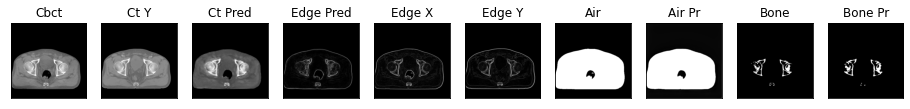

98it [00:38,  2.63it/s]

ssim score = 0.8177923560142517
psnr score = 18.69541358947754
snr score = 9.337769508361816
mae error = 0.0669725090265274
air dice score = 0.9918489778618306
bone dice score = 0.8582043343675201
contour dice score = 0.22499999403953552


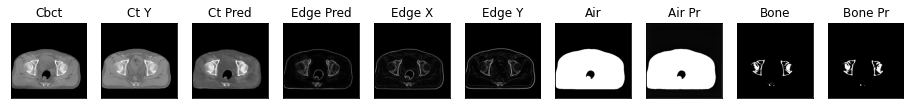

99it [00:39,  2.65it/s]

ssim score = 0.812341570854187
psnr score = 18.56878089904785
snr score = 9.217811584472656
mae error = 0.06754063814878464
air dice score = 0.9912767903816067
bone dice score = 0.8817170111306564
contour dice score = 0.23529411852359772


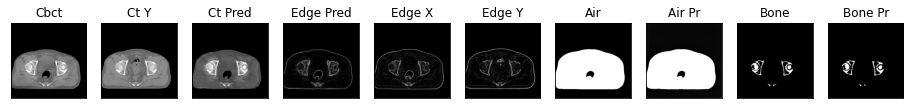

100it [00:39,  2.65it/s]

ssim score = 0.813640296459198
psnr score = 18.461902618408203
snr score = 9.141033172607422
mae error = 0.06821200996637344
air dice score = 0.9909375946558898
bone dice score = 0.9022393822408921
contour dice score = 0.21213777363300323


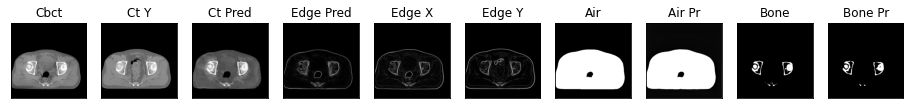

101it [00:40,  2.28it/s]

ssim score = 0.8181464672088623
psnr score = 18.70897102355957
snr score = 9.345516204833984
mae error = 0.067396380007267
air dice score = 0.9905464418311849
bone dice score = 0.9030612244914445
contour dice score = 0.22744669020175934


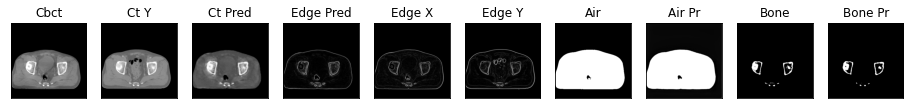

102it [00:40,  2.38it/s]

ssim score = 0.8184316754341125
psnr score = 19.029542922973633
snr score = 9.575882911682129
mae error = 0.06447852402925491
air dice score = 0.9904489722174395
bone dice score = 0.8854397634906608
contour dice score = 0.2396061271429062


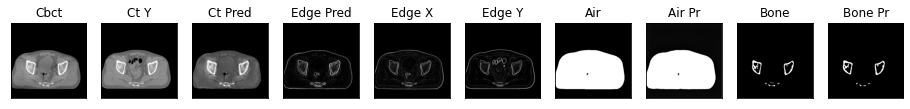

103it [00:40,  2.46it/s]

ssim score = 0.8208020925521851
psnr score = 19.106281280517578
snr score = 9.586897850036621
mae error = 0.06332981586456299
air dice score = 0.9909593377362786
bone dice score = 0.8868032943902163
contour dice score = 0.2924425005912781


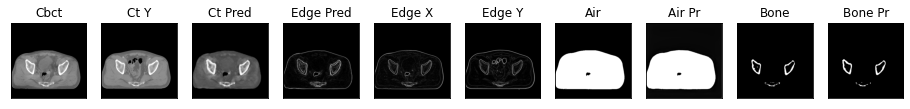

104it [00:41,  2.52it/s]

ssim score = 0.821806788444519
psnr score = 19.141237258911133
snr score = 9.621549606323242
mae error = 0.06289765983819962
air dice score = 0.990743291181511
bone dice score = 0.8779631255508699
contour dice score = 0.2888522744178772


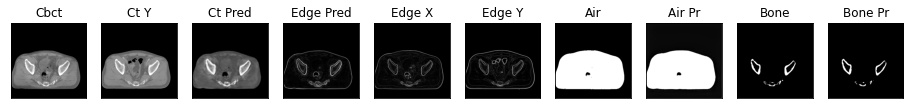

105it [00:41,  2.56it/s]

ssim score = 0.8183305263519287
psnr score = 18.92173957824707
snr score = 9.478219985961914
mae error = 0.06427396833896637
air dice score = 0.9898237692489219
bone dice score = 0.859372609030461
contour dice score = 0.39271923899650574


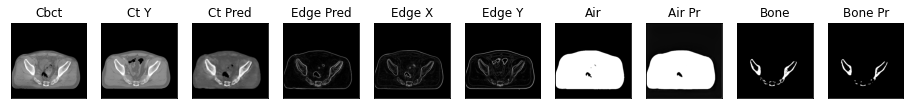

106it [00:42,  2.60it/s]

ssim score = 0.8212352991104126
psnr score = 18.99750518798828
snr score = 9.589568138122559
mae error = 0.06343621760606766
air dice score = 0.9897627118644154
bone dice score = 0.8318300843783557
contour dice score = 0.41124585270881653


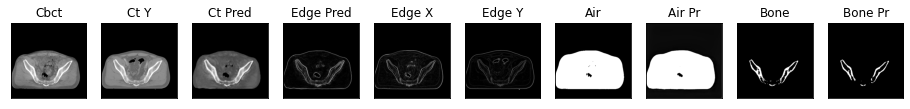

107it [00:42,  2.63it/s]

ssim score = 0.8244704008102417
psnr score = 19.326141357421875
snr score = 9.856504440307617
mae error = 0.061020758002996445
air dice score = 0.9901688504200046
bone dice score = 0.814656488552448
contour dice score = 0.4046434462070465


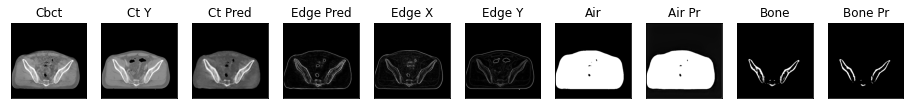

108it [00:42,  2.63it/s]

ssim score = 0.8209931254386902
psnr score = 19.440601348876953
snr score = 9.909704208374023
mae error = 0.05930927023291588
air dice score = 0.9896786824434649
bone dice score = 0.8052481821086745
contour dice score = 0.39600664377212524


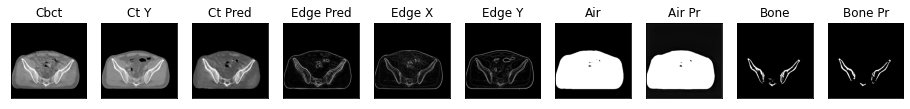

109it [00:43,  2.65it/s]

ssim score = 0.7476122975349426
psnr score = 16.849573135375977
snr score = 8.546879768371582
mae error = 0.09742669016122818
air dice score = 0.9893666369313177
bone dice score = 0.8754527723634591
contour dice score = 0.19937971234321594


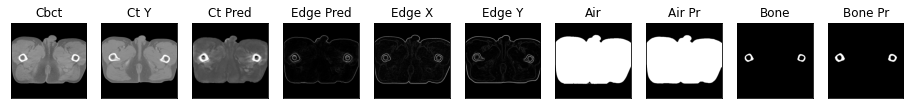

110it [00:43,  2.65it/s]

ssim score = 0.7426635026931763
psnr score = 16.559185028076172
snr score = 8.360784530639648
mae error = 0.10097959637641907
air dice score = 0.9891400787876701
bone dice score = 0.8825012607190493
contour dice score = 0.19742107391357422


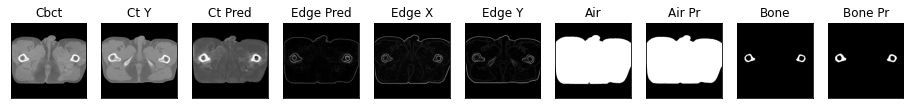

111it [00:44,  2.28it/s]

ssim score = 0.7390316128730774
psnr score = 16.2559814453125
snr score = 8.185534477233887
mae error = 0.10490214824676514
air dice score = 0.9886455463999076
bone dice score = 0.8579398286539561
contour dice score = 0.19740955531597137


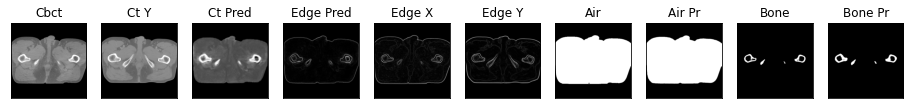

112it [00:44,  2.39it/s]

ssim score = 0.7345433831214905
psnr score = 16.002084732055664
snr score = 7.963929653167725
mae error = 0.10809099674224854
air dice score = 0.9878014318010622
bone dice score = 0.8829186383776078
contour dice score = 0.18550202250480652


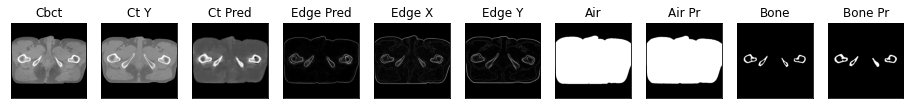

113it [00:44,  2.45it/s]

ssim score = 0.7267990112304688
psnr score = 16.03164291381836
snr score = 8.023723602294922
mae error = 0.10746835172176361
air dice score = 0.9877084079657575
bone dice score = 0.8435075391620039
contour dice score = 0.1846427023410797


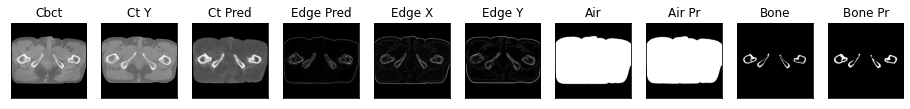

114it [00:45,  2.51it/s]

ssim score = 0.718438982963562
psnr score = 15.968048095703125
snr score = 7.994546890258789
mae error = 0.10792428255081177
air dice score = 0.9876929202089114
bone dice score = 0.8589816933658613
contour dice score = 0.1793164610862732


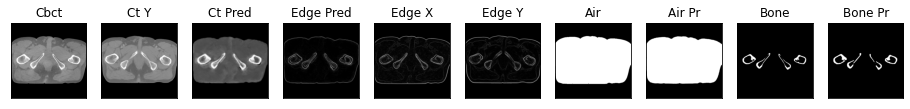

115it [00:45,  2.55it/s]

ssim score = 0.711552619934082
psnr score = 15.7963285446167
snr score = 7.843136787414551
mae error = 0.11022733151912689
air dice score = 0.9873761827536796
bone dice score = 0.8769131832813258
contour dice score = 0.20835204422473907


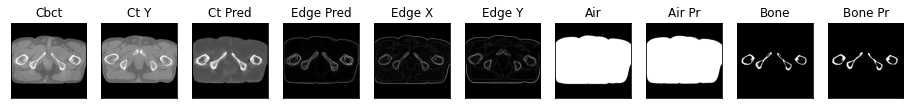

116it [00:46,  2.59it/s]

ssim score = 0.7068995833396912
psnr score = 15.714546203613281
snr score = 7.80042839050293
mae error = 0.11142848432064056
air dice score = 0.9870010366556865
bone dice score = 0.8853714577497399
contour dice score = 0.21873599290847778


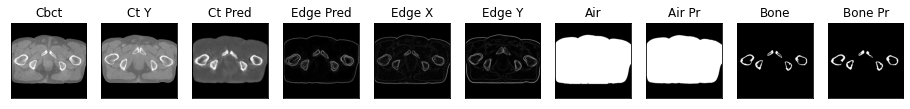

117it [00:46,  2.61it/s]

ssim score = 0.7024154663085938
psnr score = 15.65101146697998
snr score = 7.785572528839111
mae error = 0.11280352622270584
air dice score = 0.986778447297187
bone dice score = 0.8850200400816004
contour dice score = 0.17847992479801178


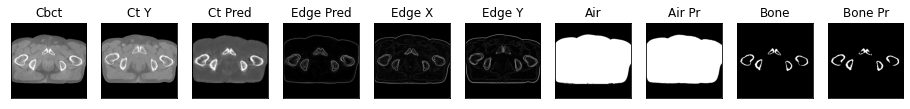

118it [00:46,  2.62it/s]

ssim score = 0.6882050037384033
psnr score = 15.51378059387207
snr score = 7.670951843261719
mae error = 0.11451522260904312
air dice score = 0.9866422988050901
bone dice score = 0.887438036514479
contour dice score = 0.16491375863552094


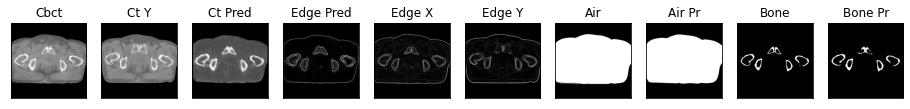

119it [00:47,  2.64it/s]

ssim score = 0.6761210560798645
psnr score = 15.434934616088867
snr score = 7.634886741638184
mae error = 0.11533866822719574
air dice score = 0.9872892919978937
bone dice score = 0.8767154620325169
contour dice score = 0.15595188736915588


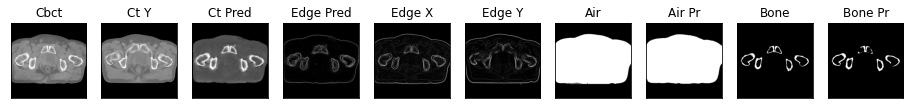

120it [00:47,  2.65it/s]

ssim score = 0.6764863729476929
psnr score = 15.547451972961426
snr score = 7.805740833282471
mae error = 0.11338745057582855
air dice score = 0.9864808507680624
bone dice score = 0.8706638115645539
contour dice score = 0.13315339386463165


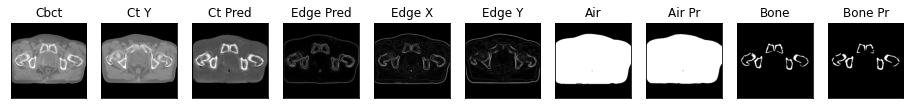

121it [00:48,  2.28it/s]

ssim score = 0.6739417910575867
psnr score = 15.668829917907715
snr score = 7.851747989654541
mae error = 0.11155123263597488
air dice score = 0.9868446183318844
bone dice score = 0.8269584782181738
contour dice score = 0.10737033933401108


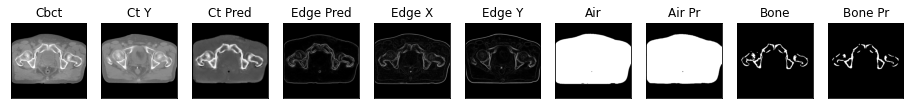

122it [00:48,  2.38it/s]

ssim score = 0.6847505569458008
psnr score = 15.923269271850586
snr score = 7.99896764755249
mae error = 0.10780266672372818
air dice score = 0.9863787663897732
bone dice score = 0.8203780450841971
contour dice score = 0.11898273974657059


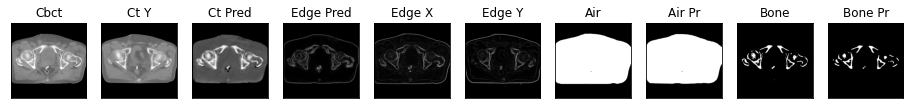

123it [00:48,  2.45it/s]

ssim score = 0.7042569518089294
psnr score = 16.290691375732422
snr score = 8.243303298950195
mae error = 0.1028834655880928
air dice score = 0.9867672448755016
bone dice score = 0.7904142134098706
contour dice score = 0.08719596266746521


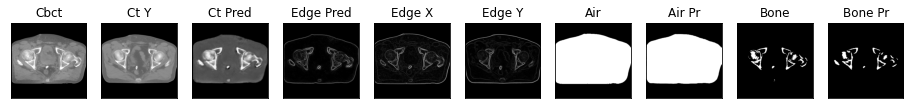

124it [00:49,  2.51it/s]

ssim score = 0.7123937606811523
psnr score = 16.466644287109375
snr score = 8.306825637817383
mae error = 0.10048789530992508
air dice score = 0.9874843263827686
bone dice score = 0.8525912899570437
contour dice score = 0.06403712183237076


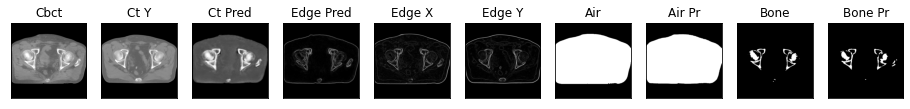

125it [00:49,  2.55it/s]

ssim score = 0.7180745005607605
psnr score = 16.620323181152344
snr score = 8.409857749938965
mae error = 0.09881339222192764
air dice score = 0.9876442618275856
bone dice score = 0.8881685575375996
contour dice score = 0.1549815535545349


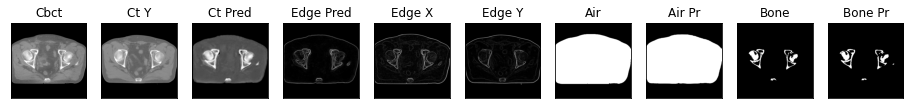

126it [00:50,  2.59it/s]

ssim score = 0.7175429463386536
psnr score = 16.513734817504883
snr score = 8.335424423217773
mae error = 0.10021273046731949
air dice score = 0.9881260945709351
bone dice score = 0.8848497808202197
contour dice score = 0.10009099543094635


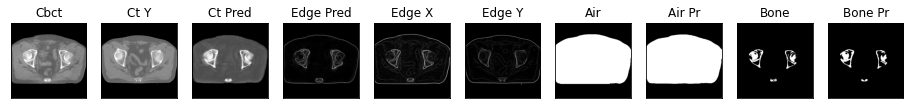

127it [00:50,  2.61it/s]

ssim score = 0.7141991853713989
psnr score = 16.432865142822266
snr score = 8.268031120300293
mae error = 0.10080499202013016
air dice score = 0.9875696276751759
bone dice score = 0.886058676371548
contour dice score = 0.0980573520064354


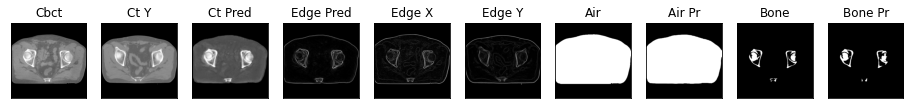

128it [00:50,  2.63it/s]

ssim score = 0.7133539319038391
psnr score = 16.42104721069336
snr score = 8.114720344543457
mae error = 0.10054652392864227
air dice score = 0.9872499955790629
bone dice score = 0.9049731496625615
contour dice score = 0.12775735557079315


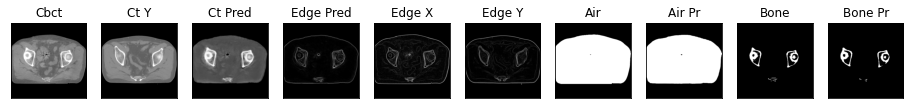

129it [00:51,  2.62it/s]

ssim score = 0.7224098443984985
psnr score = 16.599990844726562
snr score = 8.234357833862305
mae error = 0.09817017614841461
air dice score = 0.9873452218733412
bone dice score = 0.897152515929045
contour dice score = 0.12676697969436646


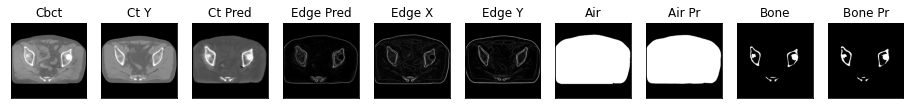

130it [00:51,  2.64it/s]

ssim score = 0.7231221199035645
psnr score = 16.843360900878906
snr score = 8.503376007080078
mae error = 0.09555637836456299
air dice score = 0.9875302814763744
bone dice score = 0.8121924114968695
contour dice score = 0.08635097742080688


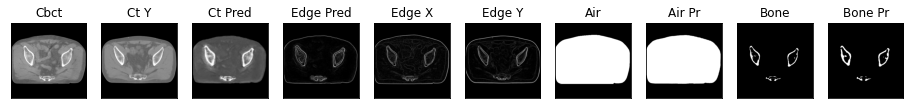

131it [00:52,  2.27it/s]

ssim score = 0.7188842296600342
psnr score = 16.571033477783203
snr score = 8.303860664367676
mae error = 0.09845707565546036
air dice score = 0.9873952344773614
bone dice score = 0.8464174454852583
contour dice score = 0.10679157078266144


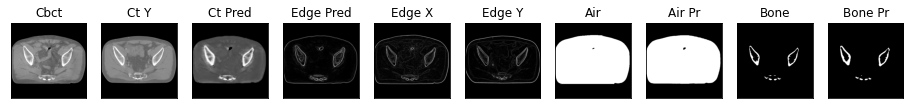

132it [00:52,  2.38it/s]

ssim score = 0.7077168822288513
psnr score = 16.100332260131836
snr score = 7.9623894691467285
mae error = 0.10333748161792755
air dice score = 0.9872203126599043
bone dice score = 0.8587938953940022
contour dice score = 0.10219675302505493


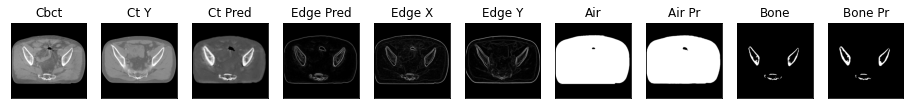

133it [00:52,  2.45it/s]

ssim score = 0.7015677094459534
psnr score = 15.993699073791504
snr score = 7.889716148376465
mae error = 0.10468414425849915
air dice score = 0.9869439364395055
bone dice score = 0.8721762312351315
contour dice score = 0.09537572413682938


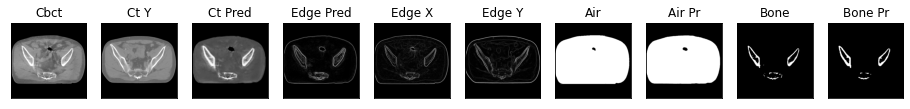

134it [00:53,  2.52it/s]

ssim score = 0.6967771649360657
psnr score = 16.0262451171875
snr score = 7.892470359802246
mae error = 0.10434295982122421
air dice score = 0.9867971966816953
bone dice score = 0.8676680972834088
contour dice score = 0.0907335877418518


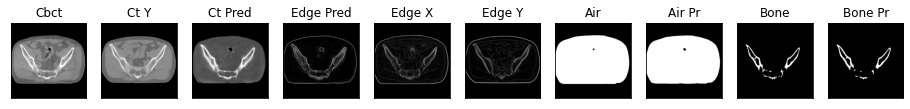

135it [00:53,  2.56it/s]

ssim score = 0.7009274959564209
psnr score = 16.35915184020996
snr score = 8.162002563476562
mae error = 0.10040324181318283
air dice score = 0.9874665042631015
bone dice score = 0.8132626648611702
contour dice score = 0.09015996009111404


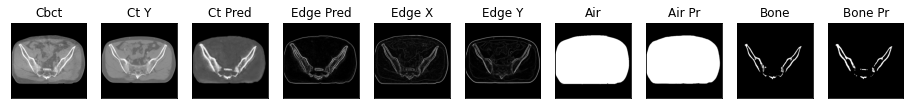

136it [00:53,  2.59it/s]

ssim score = 0.771348237991333
psnr score = 17.108251571655273
snr score = 8.585643768310547
mae error = 0.08639790117740631
air dice score = 0.9914207682716919
bone dice score = 0.8406020841394494
contour dice score = 0.07661290466785431


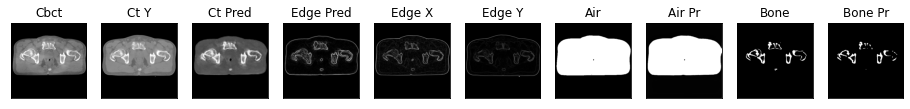

137it [00:54,  2.62it/s]

ssim score = 0.7743281126022339
psnr score = 17.08429527282715
snr score = 8.601699829101562
mae error = 0.08650103211402893
air dice score = 0.9914173942792609
bone dice score = 0.8249733191058568
contour dice score = 0.05468354374170303


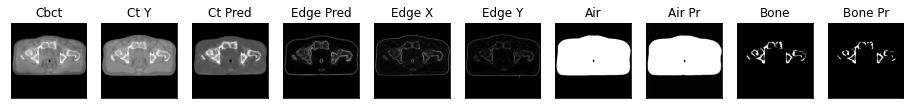

138it [00:54,  2.62it/s]

ssim score = 0.7744928002357483
psnr score = 17.10649871826172
snr score = 8.631688117980957
mae error = 0.08605016022920609
air dice score = 0.9916271592626008
bone dice score = 0.7794384690630055
contour dice score = 0.04272634908556938


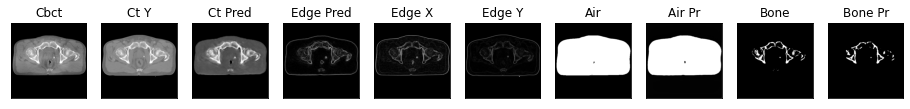

139it [00:55,  2.63it/s]

ssim score = 0.7759549021720886
psnr score = 17.102067947387695
snr score = 8.568839073181152
mae error = 0.08590267598628998
air dice score = 0.9913366891215766
bone dice score = 0.8006787625662357
contour dice score = 0.04691483825445175


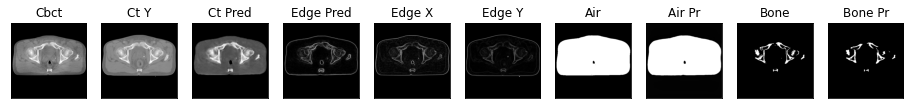

140it [00:55,  2.65it/s]

ssim score = 0.7860528826713562
psnr score = 17.31470489501953
snr score = 8.625850677490234
mae error = 0.0835014134645462
air dice score = 0.992300151901771
bone dice score = 0.8219458668643461
contour dice score = 0.08388746529817581


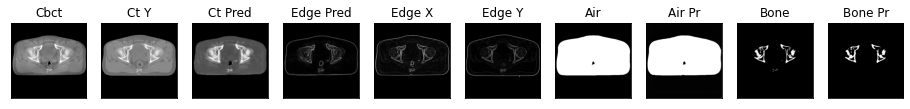

141it [00:56,  2.28it/s]

ssim score = 0.7889796495437622
psnr score = 17.339740753173828
snr score = 8.630083084106445
mae error = 0.08315801620483398
air dice score = 0.991966877433007
bone dice score = 0.8560428983932896
contour dice score = 0.11504879593849182


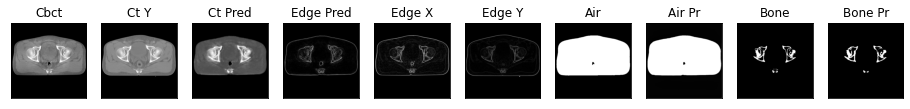

142it [00:56,  2.39it/s]

ssim score = 0.7891150116920471
psnr score = 17.35417938232422
snr score = 8.628890991210938
mae error = 0.08278101682662964
air dice score = 0.9920585979214042
bone dice score = 0.8678479642923327
contour dice score = 0.14212152361869812


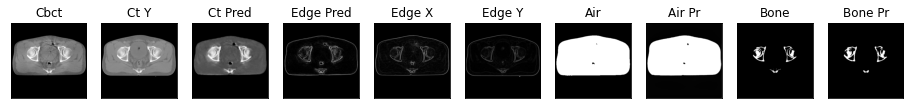

143it [00:56,  2.46it/s]

ssim score = 0.783750057220459
psnr score = 17.28769302368164
snr score = 8.571769714355469
mae error = 0.08337770402431488
air dice score = 0.9919739057556897
bone dice score = 0.8543064876977865
contour dice score = 0.1735537201166153


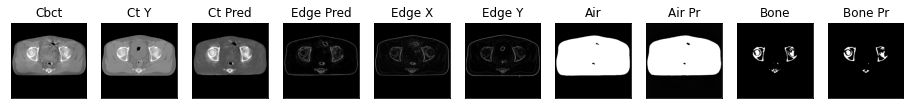

144it [00:57,  2.52it/s]

ssim score = 0.777959942817688
psnr score = 17.17129135131836
snr score = 8.511150360107422
mae error = 0.08484773337841034
air dice score = 0.9922139574262274
bone dice score = 0.8821971281209787
contour dice score = 0.1369294673204422


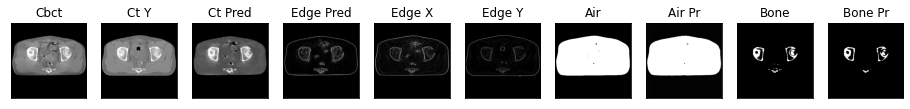

145it [00:57,  2.56it/s]

ssim score = 0.78041672706604
psnr score = 17.154239654541016
snr score = 8.47216796875
mae error = 0.08465690165758133
air dice score = 0.9917614154557125
bone dice score = 0.8889843861926804
contour dice score = 0.11145833134651184


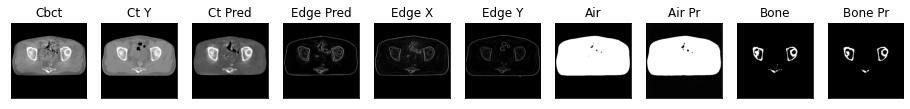

146it [00:57,  2.60it/s]

ssim score = 0.7823885083198547
psnr score = 17.17609977722168
snr score = 8.42325496673584
mae error = 0.08383014053106308
air dice score = 0.9916595511100332
bone dice score = 0.8703098240717685
contour dice score = 0.16431188583374023


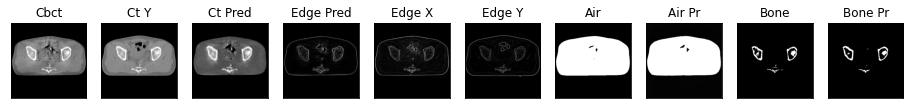

147it [00:58,  2.62it/s]

ssim score = 0.7826567888259888
psnr score = 17.322566986083984
snr score = 8.52582836151123
mae error = 0.0825832188129425
air dice score = 0.9920913951023146
bone dice score = 0.8726682887287482
contour dice score = 0.21522310376167297


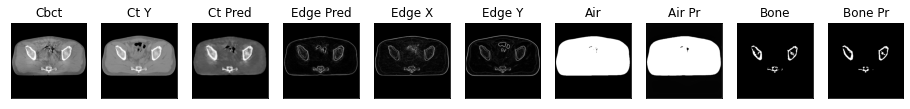

148it [00:58,  2.63it/s]

ssim score = 0.7847261428833008
psnr score = 17.399723052978516
snr score = 8.601888656616211
mae error = 0.08185485005378723
air dice score = 0.9921976592977954
bone dice score = 0.8832223485482666
contour dice score = 0.24472573399543762


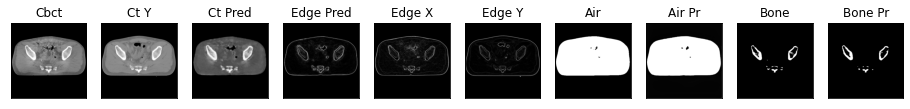

149it [00:59,  2.64it/s]

ssim score = 0.7810511589050293
psnr score = 17.334915161132812
snr score = 8.550435066223145
mae error = 0.08180873841047287
air dice score = 0.9906804642879148
bone dice score = 0.8773807649948469
contour dice score = 0.29371368885040283


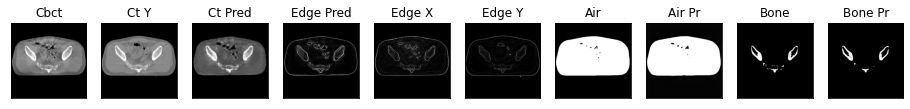

150it [00:59,  2.66it/s]

ssim score = 0.7774149179458618
psnr score = 17.270490646362305
snr score = 8.541214942932129
mae error = 0.08234047889709473
air dice score = 0.9903116322122877
bone dice score = 0.8712951684954487
contour dice score = 0.3047619163990021


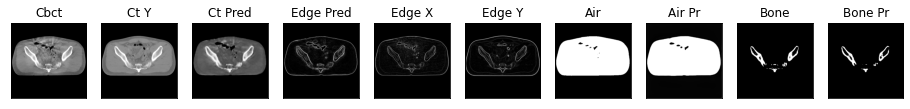

151it [01:00,  2.28it/s]

ssim score = 0.7769853472709656
psnr score = 17.220901489257812
snr score = 8.510997772216797
mae error = 0.08261913061141968
air dice score = 0.9895633619889993
bone dice score = 0.8540480488841266
contour dice score = 0.2864721417427063


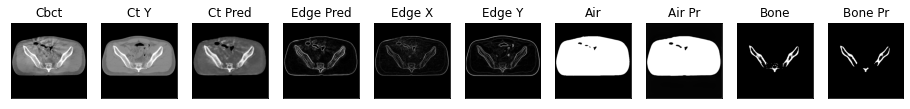

152it [01:00,  2.39it/s]

ssim score = 0.7771338820457458
psnr score = 17.422216415405273
snr score = 8.657573699951172
mae error = 0.08065278828144073
air dice score = 0.9904461552731731
bone dice score = 0.8480679156930904
contour dice score = 0.224587544798851


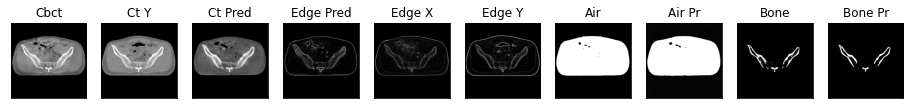

153it [01:00,  2.46it/s]

ssim score = 0.779566764831543
psnr score = 17.639751434326172
snr score = 8.838756561279297
mae error = 0.07844630628824234
air dice score = 0.9910897133716191
bone dice score = 0.8149876075256599
contour dice score = 0.18599678575992584


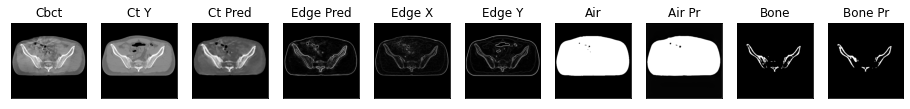

154it [01:01,  2.51it/s]

ssim score = 0.7854529023170471
psnr score = 17.701929092407227
snr score = 8.901005744934082
mae error = 0.07799456268548965
air dice score = 0.9908227089631356
bone dice score = 0.8014981273434791
contour dice score = 0.1470746099948883


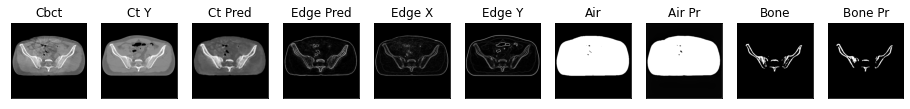

155it [01:01,  2.56it/s]

ssim score = 0.781492292881012
psnr score = 17.713808059692383
snr score = 8.911462783813477
mae error = 0.07735887914896011
air dice score = 0.9906207644348134
bone dice score = 0.7931459904072221
contour dice score = 0.13275769352912903


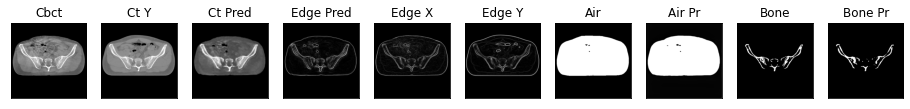

156it [01:01,  2.59it/s]

ssim score = 0.774183452129364
psnr score = 17.557939529418945
snr score = 8.760631561279297
mae error = 0.07772193104028702
air dice score = 0.9887516421669695
bone dice score = 0.7984801576161205
contour dice score = 0.10217390954494476


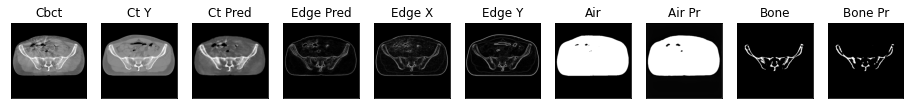

157it [01:02,  2.62it/s]

ssim score = 0.7724223136901855
psnr score = 17.4973201751709
snr score = 8.6827392578125
mae error = 0.07772700488567352
air dice score = 0.98799634976719
bone dice score = 0.7947459584325238
contour dice score = 0.16830600798130035


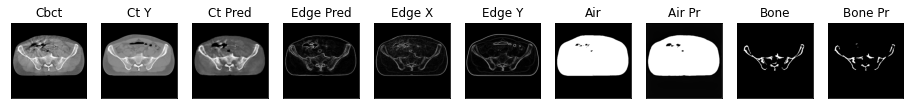

158it [01:02,  2.63it/s]

ssim score = 0.768458902835846
psnr score = 17.449148178100586
snr score = 8.615943908691406
mae error = 0.07766398787498474
air dice score = 0.987980863342034
bone dice score = 0.7838134430756678
contour dice score = 0.1771177053451538


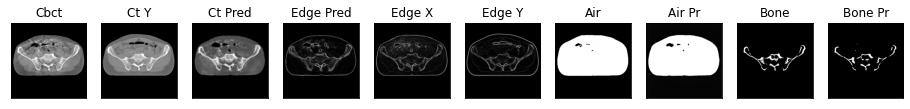

159it [01:03,  2.64it/s]

ssim score = 0.76459139585495
psnr score = 17.37558364868164
snr score = 8.496442794799805
mae error = 0.07785613089799881
air dice score = 0.9882814954445583
bone dice score = 0.7495172413827653
contour dice score = 0.1627907007932663


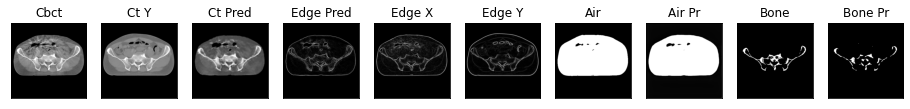

160it [01:03,  2.65it/s]

ssim score = 0.7618207931518555
psnr score = 17.33967399597168
snr score = 8.40673542022705
mae error = 0.07813556492328644
air dice score = 0.9881490242460176
bone dice score = 0.777138267972465
contour dice score = 0.19566425681114197


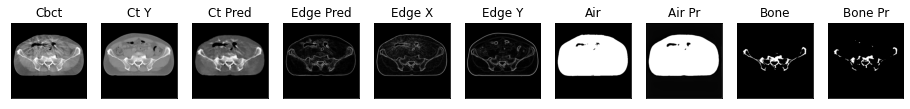

161it [01:03,  2.27it/s]

ssim score = 0.758858323097229
psnr score = 17.155427932739258
snr score = 8.252951622009277
mae error = 0.08093255013227463
air dice score = 0.9880959918951528
bone dice score = 0.7854208084852827
contour dice score = 0.18983808159828186


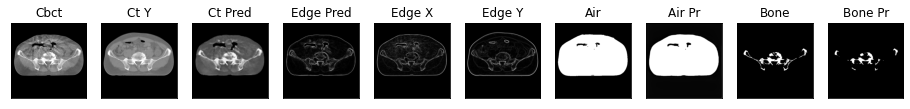

162it [01:04,  2.38it/s]

ssim score = 0.7556290626525879
psnr score = 17.220050811767578
snr score = 8.262350082397461
mae error = 0.07943638414144516
air dice score = 0.9884332115081312
bone dice score = 0.8037181732479628
contour dice score = 0.21974344551563263


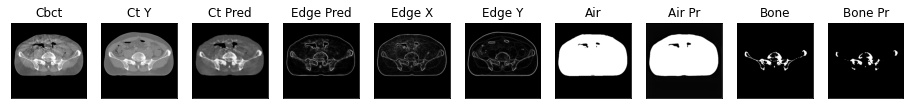

163it [01:04,  2.45it/s]

ssim score = 0.7662453651428223
psnr score = 17.71426010131836
snr score = 8.609027862548828
mae error = 0.07501211762428284
air dice score = 0.9893317469760148
bone dice score = 0.824510212591017
contour dice score = 0.1554809808731079


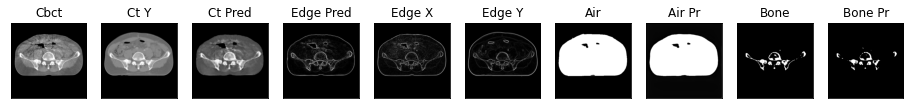

164it [01:05,  2.51it/s]

ssim score = 0.8119326829910278
psnr score = 19.889446258544922
snr score = 10.270357131958008
mae error = 0.0599520206451416
air dice score = 0.9915659366966525
bone dice score = 0.865613608751747
contour dice score = 0.19056878983974457


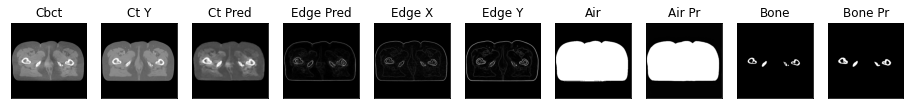

165it [01:05,  2.56it/s]

ssim score = 0.8093785643577576
psnr score = 19.67955780029297
snr score = 10.181482315063477
mae error = 0.06209754943847656
air dice score = 0.991285881663744
bone dice score = 0.8566761943679732
contour dice score = 0.15255077183246613


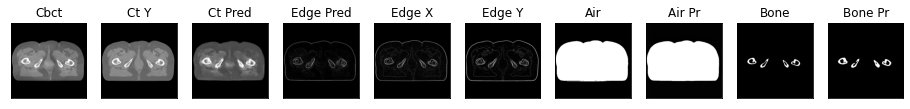

166it [01:05,  2.59it/s]

ssim score = 0.8050399422645569
psnr score = 19.431392669677734
snr score = 10.0162353515625
mae error = 0.06432076543569565
air dice score = 0.990722400233039
bone dice score = 0.8491620111759932
contour dice score = 0.1146496832370758


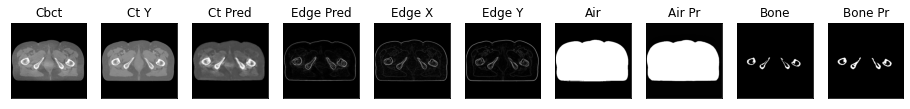

167it [01:06,  2.62it/s]

ssim score = 0.80238276720047
psnr score = 19.28178596496582
snr score = 9.930070877075195
mae error = 0.06544046103954315
air dice score = 0.9904789529023672
bone dice score = 0.8643724696379155
contour dice score = 0.09202153980731964


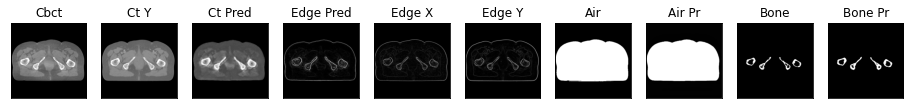

168it [01:06,  2.64it/s]

ssim score = 0.8010638356208801
psnr score = 19.21988868713379
snr score = 9.896636962890625
mae error = 0.06598109006881714
air dice score = 0.9902345585312152
bone dice score = 0.8938140919633838
contour dice score = 0.07802469283342361


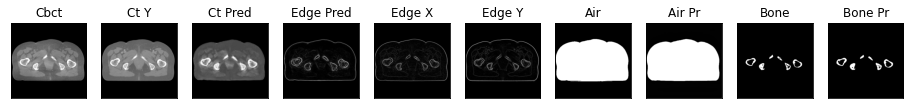

169it [01:06,  2.64it/s]

ssim score = 0.798933744430542
psnr score = 19.196460723876953
snr score = 9.896164894104004
mae error = 0.06619031727313995
air dice score = 0.9902163646981708
bone dice score = 0.8782800067736874
contour dice score = 0.08793356269598007


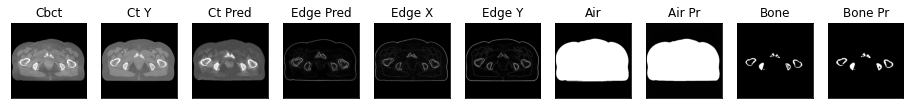

170it [01:07,  2.66it/s]

ssim score = 0.795484185218811
psnr score = 19.137374877929688
snr score = 9.868403434753418
mae error = 0.06672073155641556
air dice score = 0.9898254349734555
bone dice score = 0.8791208791228917
contour dice score = 0.0853954404592514


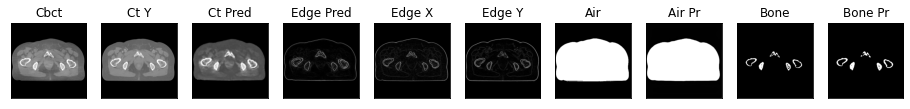

171it [01:07,  2.28it/s]

ssim score = 0.7923926115036011
psnr score = 19.000585556030273
snr score = 9.77997875213623
mae error = 0.06745102256536484
air dice score = 0.9893857839931662
bone dice score = 0.8663671159949016
contour dice score = 0.0886792466044426


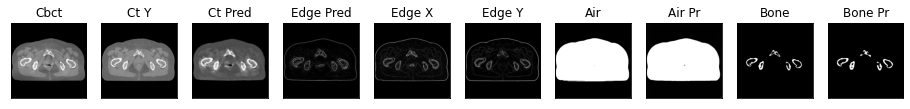

172it [01:08,  2.39it/s]

ssim score = 0.7943547964096069
psnr score = 18.927654266357422
snr score = 9.74979305267334
mae error = 0.06788330525159836
air dice score = 0.9893646855786938
bone dice score = 0.865732724699107
contour dice score = 0.08192770928144455


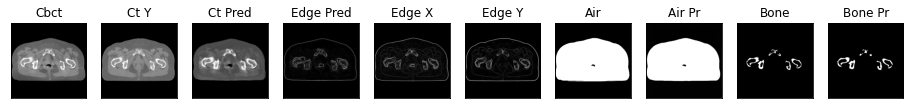

173it [01:08,  2.47it/s]

ssim score = 0.7907030582427979
psnr score = 18.8016300201416
snr score = 9.711467742919922
mae error = 0.06839269399642944
air dice score = 0.9888644309206347
bone dice score = 0.8568965517261941
contour dice score = 0.07868852466344833


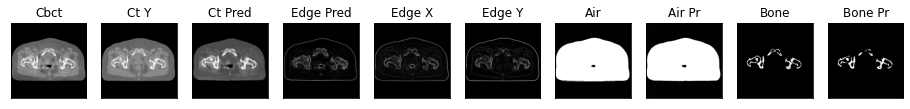

174it [01:09,  2.52it/s]

ssim score = 0.792477011680603
psnr score = 18.689281463623047
snr score = 9.712392807006836
mae error = 0.0704754963517189
air dice score = 0.9886650866050476
bone dice score = 0.8569998748923183
contour dice score = 0.08888889104127884


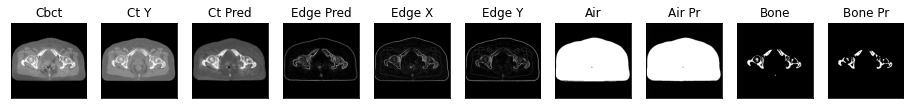

175it [01:09,  2.57it/s]

ssim score = 0.7962999939918518
psnr score = 18.781675338745117
snr score = 9.67623519897461
mae error = 0.06899908930063248
air dice score = 0.9888658670356616
bone dice score = 0.8349241120351287
contour dice score = 0.09519408643245697


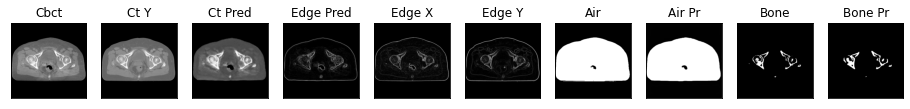

176it [01:09,  2.60it/s]

ssim score = 0.7982607483863831
psnr score = 18.904403686523438
snr score = 9.689544677734375
mae error = 0.06835445761680603
air dice score = 0.9895166487647765
bone dice score = 0.8075548749394664
contour dice score = 0.1244153380393982


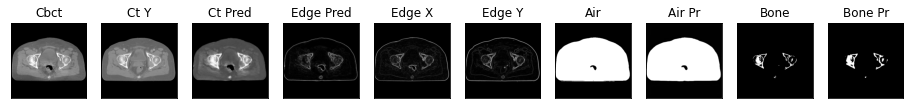

177it [01:10,  2.62it/s]

ssim score = 0.7993637323379517
psnr score = 18.97850227355957
snr score = 9.7365140914917
mae error = 0.06769008934497833
air dice score = 0.9897954082907917
bone dice score = 0.8698814229269584
contour dice score = 0.14298808574676514


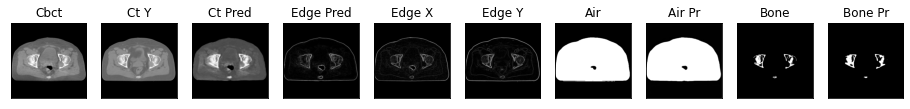

178it [01:10,  2.64it/s]

ssim score = 0.805637776851654
psnr score = 19.249759674072266
snr score = 9.999767303466797
mae error = 0.06614885479211807
air dice score = 0.9899341932833302
bone dice score = 0.8852863980255475
contour dice score = 0.11775700747966766


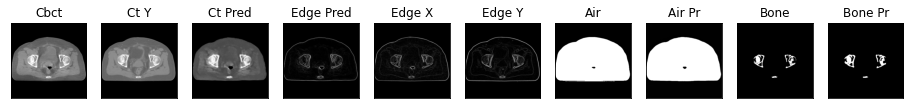

179it [01:10,  2.64it/s]

ssim score = 0.8086477518081665
psnr score = 19.36103057861328
snr score = 10.145268440246582
mae error = 0.06626011431217194
air dice score = 0.9903865735051506
bone dice score = 0.898829180427817
contour dice score = 0.11875589191913605


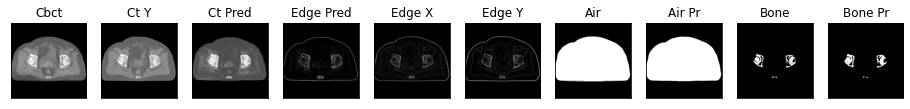

180it [01:11,  2.65it/s]

ssim score = 0.8036823868751526
psnr score = 19.202442169189453
snr score = 10.03817081451416
mae error = 0.06775862723588943
air dice score = 0.9902563208369728
bone dice score = 0.9113345521037274
contour dice score = 0.11282546073198318


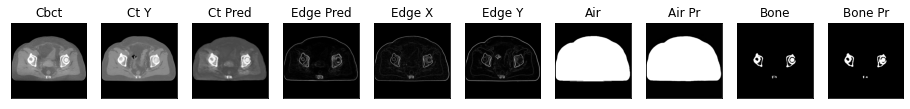

181it [01:11,  2.28it/s]

ssim score = 0.7929067015647888
psnr score = 18.98308753967285
snr score = 9.85637378692627
mae error = 0.06958212703466415
air dice score = 0.9904736867593306
bone dice score = 0.9077574967420509
contour dice score = 0.10082404315471649


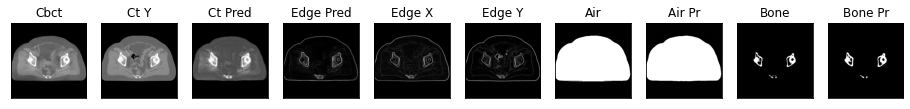

182it [01:12,  2.38it/s]

ssim score = 0.7753170132637024
psnr score = 18.80978775024414
snr score = 9.610639572143555
mae error = 0.06981045007705688
air dice score = 0.9897341875588037
bone dice score = 0.8409619860387711
contour dice score = 0.09304603189229965


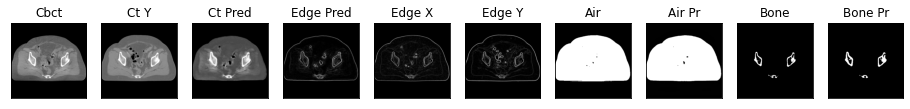

183it [01:12,  2.46it/s]

ssim score = 0.7689573168754578
psnr score = 18.732301712036133
snr score = 9.515159606933594
mae error = 0.07012469321489334
air dice score = 0.989694945811402
bone dice score = 0.8619729514745034
contour dice score = 0.08415841311216354


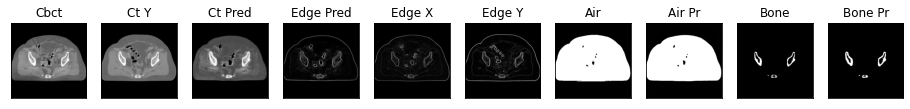

184it [01:13,  2.52it/s]

ssim score = 0.7689210772514343
psnr score = 18.749752044677734
snr score = 9.597522735595703
mae error = 0.07038064301013947
air dice score = 0.9889672806477654
bone dice score = 0.867004680189801
contour dice score = 0.07619990408420563


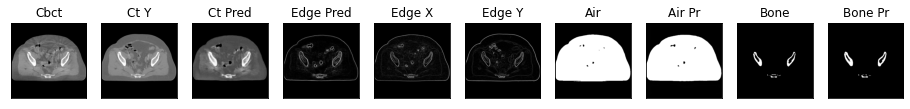

185it [01:13,  2.56it/s]

ssim score = 0.7721980214118958
psnr score = 18.77570915222168
snr score = 9.67857551574707
mae error = 0.07106179744005203
air dice score = 0.9884377556905903
bone dice score = 0.8812457221101772
contour dice score = 0.06686626374721527


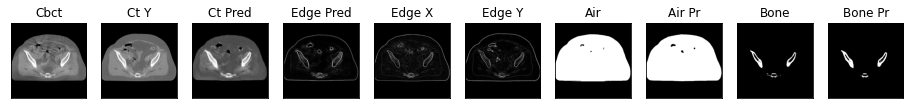

186it [01:13,  2.60it/s]

ssim score = 0.7674960494041443
psnr score = 18.519563674926758
snr score = 9.486858367919922
mae error = 0.07336484640836716
air dice score = 0.9882004331823032
bone dice score = 0.889309090910701
contour dice score = 0.06903353333473206


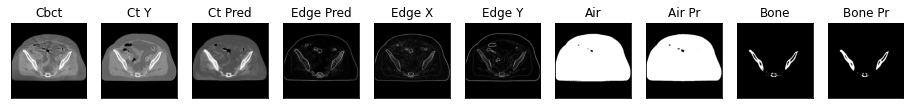

187it [01:14,  2.61it/s]

ssim score = 0.7624902725219727
psnr score = 18.36934471130371
snr score = 9.40949821472168
mae error = 0.074555903673172
air dice score = 0.9877681285566472
bone dice score = 0.8525519848791175
contour dice score = 0.06324110925197601


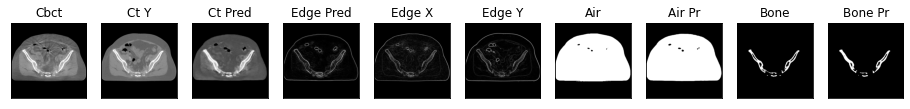

188it [01:14,  2.62it/s]

ssim score = 0.7603313326835632
psnr score = 18.367549896240234
snr score = 9.403414726257324
mae error = 0.07434267550706863
air dice score = 0.9867110069521814
bone dice score = 0.8470588235314799
contour dice score = 0.0665687695145607


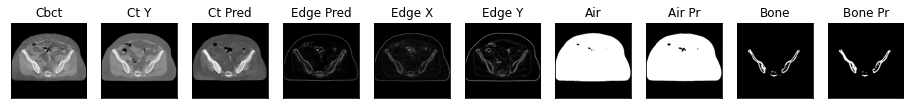

189it [01:14,  2.63it/s]

ssim score = 0.759269654750824
psnr score = 18.514869689941406
snr score = 9.528556823730469
mae error = 0.073298379778862
air dice score = 0.987832374436332
bone dice score = 0.835213276288925
contour dice score = 0.06712061911821365


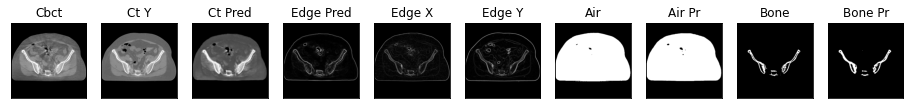

190it [01:15,  2.63it/s]

ssim score = 0.7658469080924988
psnr score = 18.773784637451172
snr score = 9.79910659790039
mae error = 0.07189331203699112
air dice score = 0.9881287920131051
bone dice score = 0.843032568074706
contour dice score = 0.06573224067687988


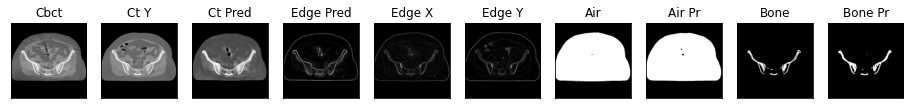

191it [01:15,  2.51it/s]


In [42]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [43]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [44]:
edge_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [45]:
# score_ssim, score_psnr, score_snr, score_mae, score_air, score_bone, score_cont, score_acc
# unmasked
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:07, 24.66it/s]


(0.7845835969710225,
 18.01836232989246,
 9.022634436322756,
 0.07668317653511832,
 0.9837569868626709,
 0.8412677190290546,
 0.23309598896281883,
 0.5,
 0.21727748691099477)

In [ ]:
# import torchvision.models as models
# models.vgg16(pretrained=True)